:# **Generative Adversarial Networks (GAN's)**
---


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
from __future__ import print_function, division

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.datasets import mnist, cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, LeakyReLU
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import load_model

# Hyper-parameters tuning

In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
num_classes = 10
latent_dim = 100

## Load and Preprocess Dataset

In [ ]:
import tensorflow as tf
import numpy as np

# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalizing the data so that it is from -1 to 1. NNs converge faster this way
x_train = x_train / 127.5 - 1.

# Checking the shape of x_train
print(x_train.shape)  # Should output: (50000, 32, 32, 3)


(50000, 32, 32, 3)


## Define function to build Generator
The generator synthesizes fake images. The fake image is generated from a 100-dimensional noise (uniform distribution between -1.0 to 1.0) using the inverse of convolution, called transposed convolution.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, Embedding, multiply, Input, Flatten
from keras.layers import Conv2D

def build_generator(latent_dim, img_shape, num_classes):
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))
    model_input = multiply([noise, label_embedding])

    x = Dense(128 * 8 * 8, activation="relu")(model_input)
    x = Reshape((8, 8, 128))(x)
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    img = Conv2D(3, kernel_size=3, padding="same", activation='tanh')(x)

    return Model([noise, label], img)

# Assuming the following dimensions and number of classes
latent_dim = 100
num_classes = 10
img_shape = (32, 32, 3)

generator = build_generator(latent_dim, img_shape, num_classes)


## Define function to build the Discriminator
Below cell shows the Keras code for the Discriminator Model. It is the Discriminator described above with the loss function defined for training. Since the output of the Discriminator is **sigmoid**, we use **binary cross entropy** for the loss.

**Note**
* In some case, RMSProp might generate more realistic image as compared to the Adam optimizer
* The Learning rate can be set to 0.0008. Weight decay and clip value stabilize learning during the latter part of the training. You have to adjust the decay if you adjust the learning rate.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, LeakyReLU, Dropout, Input
from keras.optimizers import Adam

def build_discriminator(img_shape):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])


## Define a function to Display Images

In [ ]:
import matplotlib.pyplot as plt

def display_images(generator, latent_dim, num_classes):
    noise = np.random.normal(0, 1, (10, latent_dim))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        axs[i].imshow(gen_imgs[i])
        axs[i].axis('off')
    plt.show()


## Building the Generative Adversarial Network (GAN)
The adversarial model is just the generator-discriminator stacked together as shown in the following figure The Generator part is trying to fool the Discriminator and learning from its feedback at the same time. The training parameters are the same as in the Discriminator model except for a reduced learning rate and corresponding weight decay.

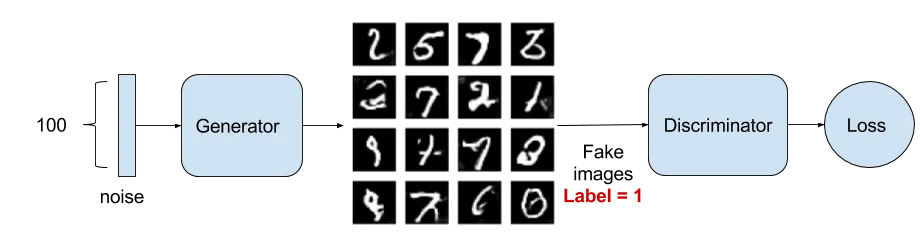

In [ ]:
from keras.layers import Input

# The generator takes noise z and label as input and generates an image
z = Input(shape=(latent_dim,))
label = Input(shape=(1,), dtype='int32')
img = generator([z, label])

# For the combined model we only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model (stacked generator and discriminator)
# Trains generator to fool discriminator
combined_network = Model([z, label], valid)
combined_network.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


# Train the Network
We determine first if Discriminator model is correct by training it alone with real and fake images. Afterwards, the Discriminator and Adversarial models are trained one after the other. Follwoing figure shows the Adversarial Model during training.

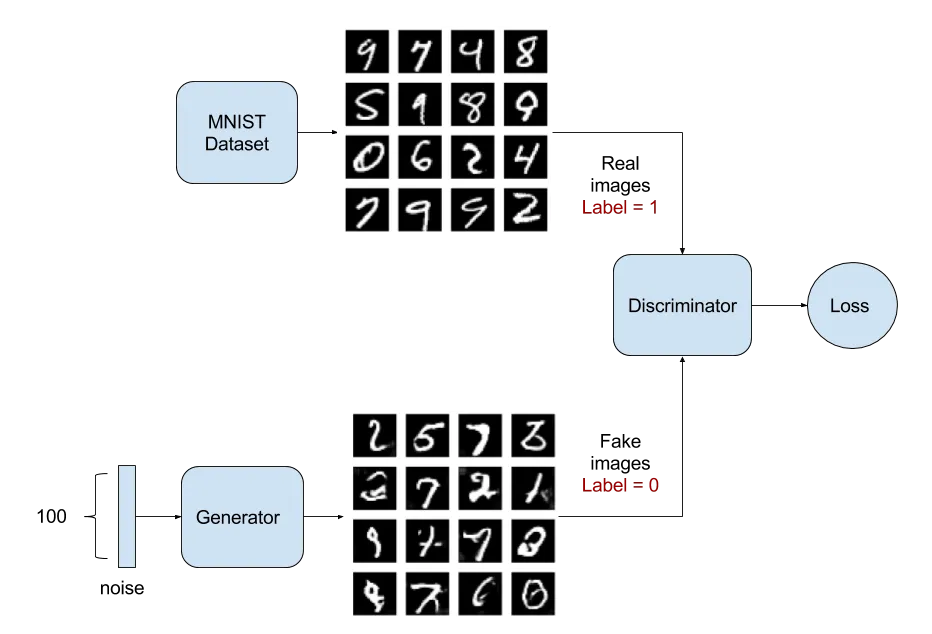

1/1 [==============================] - 0s 33ms/step
0 [D loss: 0.637864, acc.: 50.00%] [G loss: 0.692198]
1/1 [==============================] - 1s 501ms/step


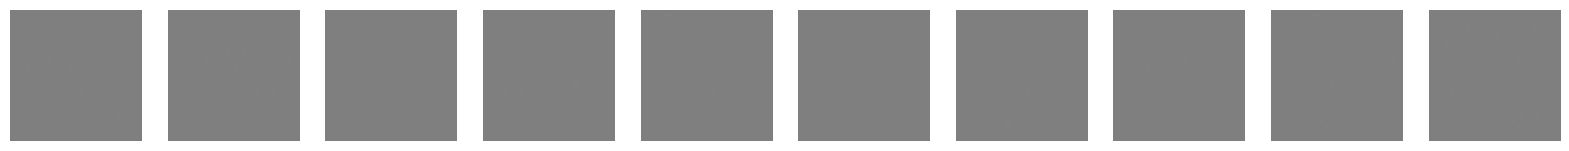

1/1 [==============================] - 0s 21ms/step
1 [D loss: 0.605633, acc.: 50.00%] [G loss: 0.691972]
1/1 [==============================] - 0s 16ms/step
2 [D loss: 0.590205, acc.: 50.00%] [G loss: 0.691505]
1/1 [==============================] - 0s 16ms/step
3 [D loss: 0.562257, acc.: 50.00%] [G loss: 0.690888]
1/1 [==============================] - 0s 17ms/step
4 [D loss: 0.531883, acc.: 50.00%] [G loss: 0.690017]
1/1 [==============================] - 0s 16ms/step
5 [D loss: 0.526468, acc.: 50.00%] [G loss: 0.688313]
1/1 [==============================] - 0s 18ms/step
6 [D loss: 0.500619, acc.: 50.00%] [G loss: 0.686752]
1/1 [==============================] - 0s 20ms/step
7 [D loss: 0.481373, acc.: 50.00%] [G loss: 0.683816]
1/1 [==============================] - 0s 18ms/step
8 [D loss: 0.449946, acc.: 50.00%] [G loss: 0.681501]
1/1 [==============================] - 0s 18ms/step
9 [D loss: 0.450072, acc.: 50.00%] [G loss: 0.677521]
1/1 [==============================] - 0s 18ms

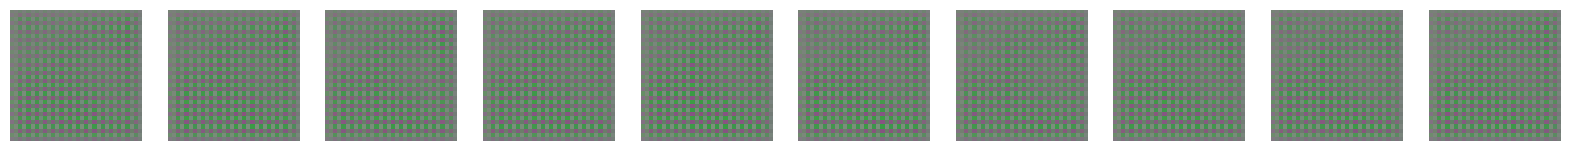

1/1 [==============================] - 0s 27ms/step
51 [D loss: 0.397093, acc.: 96.88%] [G loss: 0.908450]
1/1 [==============================] - 0s 22ms/step
52 [D loss: 0.351914, acc.: 100.00%] [G loss: 0.980591]
1/1 [==============================] - 0s 24ms/step
53 [D loss: 0.314000, acc.: 100.00%] [G loss: 1.058213]
1/1 [==============================] - 0s 24ms/step
54 [D loss: 0.292737, acc.: 100.00%] [G loss: 1.137152]
1/1 [==============================] - 0s 20ms/step
55 [D loss: 0.248344, acc.: 100.00%] [G loss: 1.254931]
1/1 [==============================] - 0s 20ms/step
56 [D loss: 0.254820, acc.: 98.44%] [G loss: 1.316569]
1/1 [==============================] - 0s 19ms/step
57 [D loss: 0.232247, acc.: 98.44%] [G loss: 1.366681]
1/1 [==============================] - 0s 23ms/step
58 [D loss: 0.223545, acc.: 100.00%] [G loss: 1.391134]
1/1 [==============================] - 0s 21ms/step
59 [D loss: 0.230600, acc.: 100.00%] [G loss: 1.393556]
1/1 [==========================

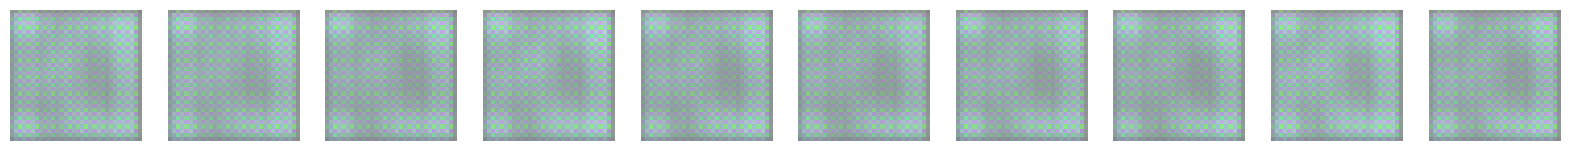

1/1 [==============================] - 0s 24ms/step
101 [D loss: 0.217661, acc.: 95.31%] [G loss: 2.328157]
1/1 [==============================] - 0s 20ms/step
102 [D loss: 0.265832, acc.: 93.75%] [G loss: 2.250414]
1/1 [==============================] - 0s 20ms/step
103 [D loss: 0.297865, acc.: 92.19%] [G loss: 2.137731]
1/1 [==============================] - 0s 22ms/step
104 [D loss: 0.437529, acc.: 87.50%] [G loss: 1.840932]
1/1 [==============================] - 0s 30ms/step
105 [D loss: 0.433027, acc.: 89.06%] [G loss: 1.807336]
1/1 [==============================] - 0s 33ms/step
106 [D loss: 0.168199, acc.: 98.44%] [G loss: 2.135893]
1/1 [==============================] - 0s 48ms/step
107 [D loss: 0.177820, acc.: 95.31%] [G loss: 2.363951]
1/1 [==============================] - 0s 36ms/step
108 [D loss: 0.235387, acc.: 92.19%] [G loss: 2.336546]
1/1 [==============================] - 0s 32ms/step
109 [D loss: 0.194726, acc.: 96.88%] [G loss: 2.390162]
1/1 [=======================

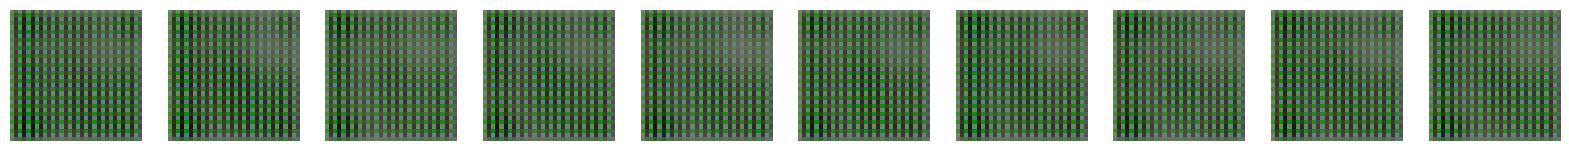

1/1 [==============================] - 0s 23ms/step
151 [D loss: 0.410516, acc.: 85.94%] [G loss: 2.430332]
1/1 [==============================] - 0s 20ms/step
152 [D loss: 0.642605, acc.: 84.38%] [G loss: 2.064066]
1/1 [==============================] - 0s 21ms/step
153 [D loss: 0.337711, acc.: 90.62%] [G loss: 2.415009]
1/1 [==============================] - 0s 20ms/step
154 [D loss: 0.504843, acc.: 82.81%] [G loss: 2.251369]
1/1 [==============================] - 0s 20ms/step
155 [D loss: 0.248319, acc.: 90.62%] [G loss: 2.626375]
1/1 [==============================] - 0s 19ms/step
156 [D loss: 0.174144, acc.: 93.75%] [G loss: 2.822224]
1/1 [==============================] - 0s 28ms/step
157 [D loss: 0.308685, acc.: 92.19%] [G loss: 2.537467]
1/1 [==============================] - 0s 20ms/step
158 [D loss: 0.167360, acc.: 98.44%] [G loss: 2.695388]
1/1 [==============================] - 0s 22ms/step
159 [D loss: 0.291215, acc.: 92.19%] [G loss: 2.573155]
1/1 [=======================

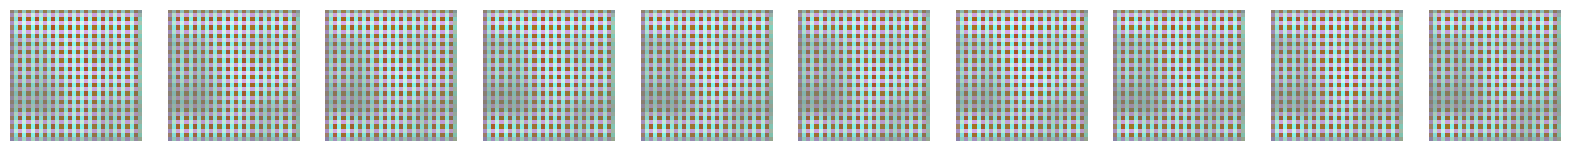

1/1 [==============================] - 0s 31ms/step
201 [D loss: 0.157467, acc.: 95.31%] [G loss: 2.792095]
1/1 [==============================] - 0s 27ms/step
202 [D loss: 0.195086, acc.: 95.31%] [G loss: 2.587675]
1/1 [==============================] - 0s 30ms/step
203 [D loss: 0.182599, acc.: 95.31%] [G loss: 2.607819]
1/1 [==============================] - 0s 29ms/step
204 [D loss: 0.170464, acc.: 96.88%] [G loss: 2.813506]
1/1 [==============================] - 0s 36ms/step
205 [D loss: 0.217612, acc.: 93.75%] [G loss: 2.695800]
1/1 [==============================] - 0s 29ms/step
206 [D loss: 0.075878, acc.: 100.00%] [G loss: 2.856052]
1/1 [==============================] - 0s 30ms/step
207 [D loss: 0.053638, acc.: 100.00%] [G loss: 3.013973]
1/1 [==============================] - 0s 36ms/step
208 [D loss: 0.134884, acc.: 95.31%] [G loss: 2.888859]
1/1 [==============================] - 0s 32ms/step
209 [D loss: 0.075808, acc.: 100.00%] [G loss: 2.966920]
1/1 [====================

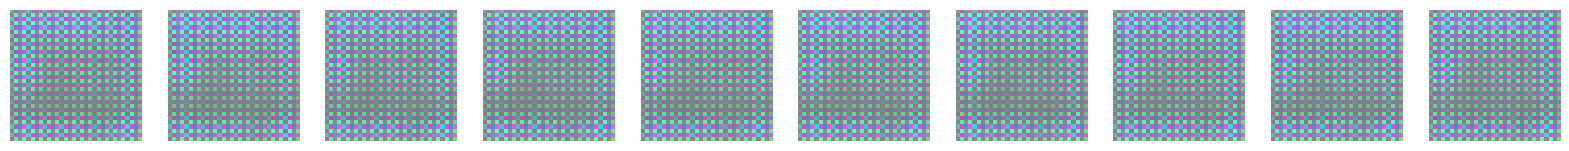

1/1 [==============================] - 0s 19ms/step
251 [D loss: 0.104560, acc.: 98.44%] [G loss: 2.993389]
1/1 [==============================] - 0s 20ms/step
252 [D loss: 0.051579, acc.: 98.44%] [G loss: 2.978543]
1/1 [==============================] - 0s 18ms/step
253 [D loss: 0.034574, acc.: 100.00%] [G loss: 3.133771]
1/1 [==============================] - 0s 19ms/step
254 [D loss: 0.028667, acc.: 100.00%] [G loss: 3.259317]
1/1 [==============================] - 0s 19ms/step
255 [D loss: 0.099506, acc.: 96.88%] [G loss: 3.176471]
1/1 [==============================] - 0s 18ms/step
256 [D loss: 0.031719, acc.: 100.00%] [G loss: 3.206950]
1/1 [==============================] - 0s 20ms/step
257 [D loss: 0.078163, acc.: 96.88%] [G loss: 3.138026]
1/1 [==============================] - 0s 19ms/step
258 [D loss: 0.062536, acc.: 98.44%] [G loss: 3.168124]
1/1 [==============================] - 0s 23ms/step
259 [D loss: 0.032592, acc.: 100.00%] [G loss: 3.276166]
1/1 [===================

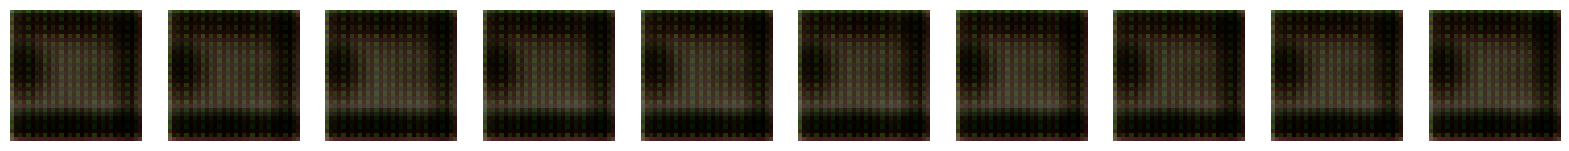

1/1 [==============================] - 0s 43ms/step
301 [D loss: 0.405080, acc.: 82.81%] [G loss: 2.902847]
1/1 [==============================] - 0s 42ms/step
302 [D loss: 0.439965, acc.: 85.94%] [G loss: 4.744254]
1/1 [==============================] - 0s 35ms/step
303 [D loss: 0.315032, acc.: 89.06%] [G loss: 5.913655]
1/1 [==============================] - 0s 35ms/step
304 [D loss: 0.478813, acc.: 85.94%] [G loss: 3.997924]
1/1 [==============================] - 0s 43ms/step
305 [D loss: 0.263463, acc.: 92.19%] [G loss: 3.266903]
1/1 [==============================] - 0s 42ms/step
306 [D loss: 0.194374, acc.: 93.75%] [G loss: 3.340732]
1/1 [==============================] - 0s 32ms/step
307 [D loss: 0.246586, acc.: 89.06%] [G loss: 3.305724]
1/1 [==============================] - 0s 39ms/step
308 [D loss: 0.110235, acc.: 96.88%] [G loss: 3.769473]
1/1 [==============================] - 0s 26ms/step
309 [D loss: 0.352446, acc.: 90.62%] [G loss: 3.098301]
1/1 [=======================

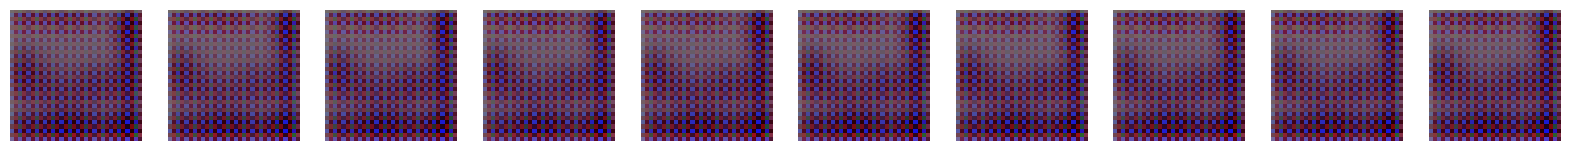

1/1 [==============================] - 0s 22ms/step
351 [D loss: 0.082761, acc.: 96.88%] [G loss: 2.758515]
1/1 [==============================] - 0s 20ms/step
352 [D loss: 0.126923, acc.: 95.31%] [G loss: 2.719872]
1/1 [==============================] - 0s 22ms/step
353 [D loss: 0.085901, acc.: 96.88%] [G loss: 2.683225]
1/1 [==============================] - 0s 21ms/step
354 [D loss: 0.120555, acc.: 95.31%] [G loss: 2.555464]
1/1 [==============================] - 0s 26ms/step
355 [D loss: 0.106603, acc.: 98.44%] [G loss: 2.528348]
1/1 [==============================] - 0s 28ms/step
356 [D loss: 0.220184, acc.: 93.75%] [G loss: 2.308947]
1/1 [==============================] - 0s 27ms/step
357 [D loss: 0.159412, acc.: 95.31%] [G loss: 2.192985]
1/1 [==============================] - 0s 24ms/step
358 [D loss: 0.111741, acc.: 98.44%] [G loss: 2.256416]
1/1 [==============================] - 0s 25ms/step
359 [D loss: 0.144490, acc.: 96.88%] [G loss: 2.173497]
1/1 [=======================

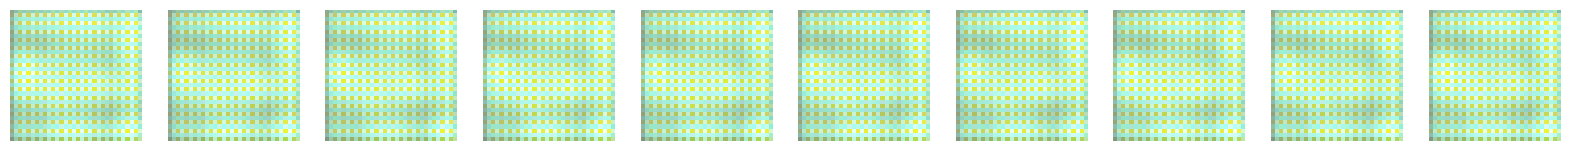

1/1 [==============================] - 0s 24ms/step
401 [D loss: 0.483395, acc.: 89.06%] [G loss: 3.302402]
1/1 [==============================] - 0s 20ms/step
402 [D loss: 0.264256, acc.: 92.19%] [G loss: 3.443042]
1/1 [==============================] - 0s 24ms/step
403 [D loss: 0.108818, acc.: 95.31%] [G loss: 3.776255]
1/1 [==============================] - 0s 19ms/step
404 [D loss: 0.227201, acc.: 93.75%] [G loss: 3.533450]
1/1 [==============================] - 0s 21ms/step
405 [D loss: 0.296659, acc.: 90.62%] [G loss: 3.226202]
1/1 [==============================] - 0s 22ms/step
406 [D loss: 0.099019, acc.: 95.31%] [G loss: 3.731012]
1/1 [==============================] - 0s 18ms/step
407 [D loss: 0.124900, acc.: 96.88%] [G loss: 3.740436]
1/1 [==============================] - 0s 20ms/step
408 [D loss: 0.108060, acc.: 96.88%] [G loss: 3.733968]
1/1 [==============================] - 0s 18ms/step
409 [D loss: 0.161249, acc.: 95.31%] [G loss: 3.403300]
1/1 [=======================

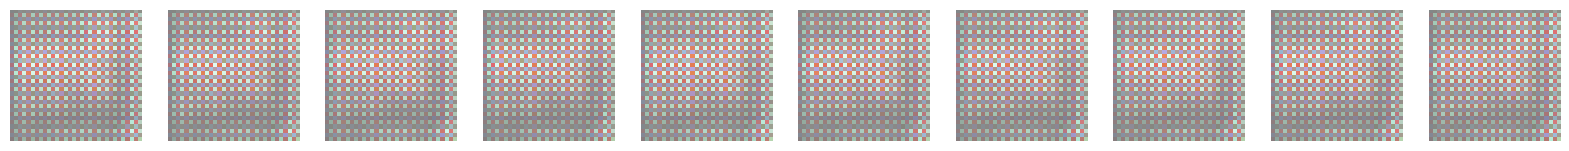

1/1 [==============================] - 0s 25ms/step
451 [D loss: 0.062201, acc.: 98.44%] [G loss: 2.947917]
1/1 [==============================] - 0s 19ms/step
452 [D loss: 0.037851, acc.: 100.00%] [G loss: 3.089275]
1/1 [==============================] - 0s 23ms/step
453 [D loss: 0.110229, acc.: 95.31%] [G loss: 2.911840]
1/1 [==============================] - 0s 19ms/step
454 [D loss: 0.037145, acc.: 100.00%] [G loss: 2.991534]
1/1 [==============================] - 0s 19ms/step
455 [D loss: 0.137733, acc.: 96.88%] [G loss: 2.636397]
1/1 [==============================] - 0s 22ms/step
456 [D loss: 0.096182, acc.: 95.31%] [G loss: 2.511816]
1/1 [==============================] - 0s 19ms/step
457 [D loss: 0.102637, acc.: 98.44%] [G loss: 2.538970]
1/1 [==============================] - 0s 25ms/step
458 [D loss: 0.098087, acc.: 96.88%] [G loss: 2.548755]
1/1 [==============================] - 0s 20ms/step
459 [D loss: 0.100881, acc.: 96.88%] [G loss: 2.573862]
1/1 [=====================

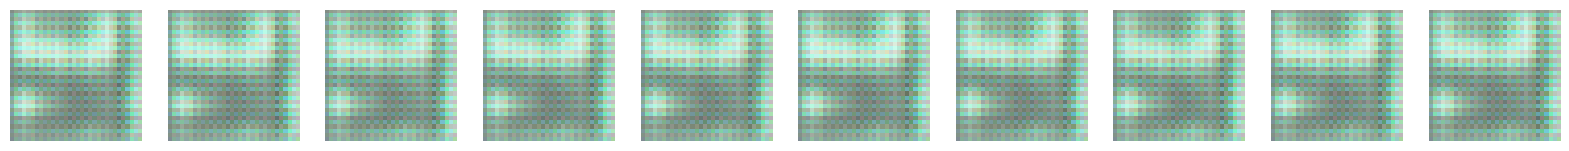

1/1 [==============================] - 0s 20ms/step
501 [D loss: 0.050269, acc.: 100.00%] [G loss: 3.231892]
1/1 [==============================] - 0s 24ms/step
502 [D loss: 0.091870, acc.: 96.88%] [G loss: 3.052763]
1/1 [==============================] - 0s 20ms/step
503 [D loss: 0.053183, acc.: 98.44%] [G loss: 3.004786]
1/1 [==============================] - 0s 28ms/step
504 [D loss: 0.081089, acc.: 96.88%] [G loss: 2.806597]
1/1 [==============================] - 0s 27ms/step
505 [D loss: 0.058918, acc.: 98.44%] [G loss: 2.863144]
1/1 [==============================] - 0s 20ms/step
506 [D loss: 0.113169, acc.: 96.88%] [G loss: 2.594234]
1/1 [==============================] - 0s 25ms/step
507 [D loss: 0.123841, acc.: 98.44%] [G loss: 2.313495]
1/1 [==============================] - 0s 20ms/step
508 [D loss: 0.304801, acc.: 95.31%] [G loss: 1.705273]
1/1 [==============================] - 0s 20ms/step
509 [D loss: 0.433497, acc.: 62.50%] [G loss: 1.427742]
1/1 [======================

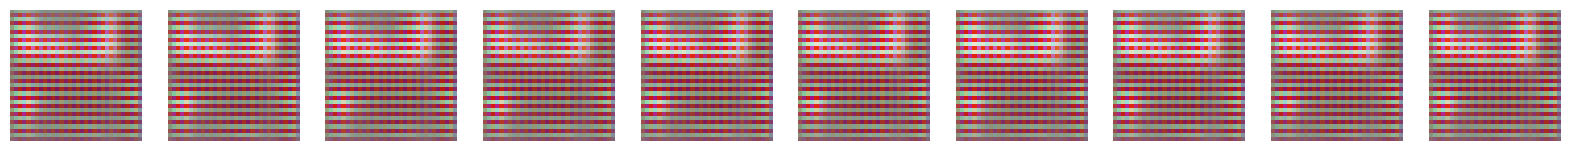

1/1 [==============================] - 0s 25ms/step
551 [D loss: 0.261921, acc.: 92.19%] [G loss: 2.347676]
1/1 [==============================] - 0s 19ms/step
552 [D loss: 0.138696, acc.: 98.44%] [G loss: 2.556712]
1/1 [==============================] - 0s 19ms/step
553 [D loss: 0.103084, acc.: 100.00%] [G loss: 2.921990]
1/1 [==============================] - 0s 32ms/step
554 [D loss: 0.127074, acc.: 96.88%] [G loss: 3.235998]
1/1 [==============================] - 0s 34ms/step
555 [D loss: 0.104475, acc.: 98.44%] [G loss: 3.557498]
1/1 [==============================] - 0s 30ms/step
556 [D loss: 0.111509, acc.: 98.44%] [G loss: 3.890834]
1/1 [==============================] - 0s 26ms/step
557 [D loss: 0.118252, acc.: 95.31%] [G loss: 4.209827]
1/1 [==============================] - 0s 31ms/step
558 [D loss: 0.083367, acc.: 98.44%] [G loss: 4.182433]
1/1 [==============================] - 0s 41ms/step
559 [D loss: 0.112426, acc.: 96.88%] [G loss: 4.584758]
1/1 [======================

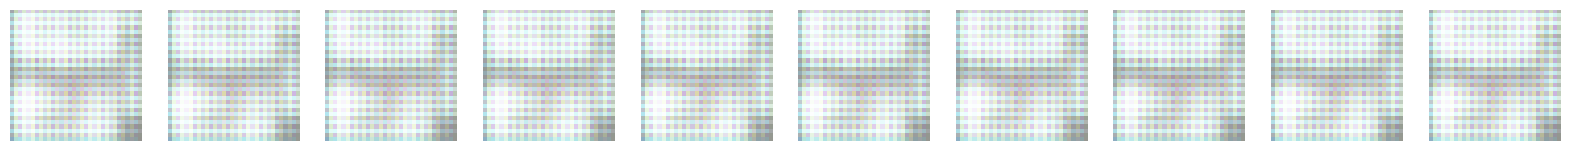

1/1 [==============================] - 0s 24ms/step
601 [D loss: 0.065914, acc.: 98.44%] [G loss: 4.203866]
1/1 [==============================] - 0s 21ms/step
602 [D loss: 0.110864, acc.: 95.31%] [G loss: 3.986031]
1/1 [==============================] - 0s 28ms/step
603 [D loss: 0.149754, acc.: 95.31%] [G loss: 3.750500]
1/1 [==============================] - 0s 28ms/step
604 [D loss: 0.134724, acc.: 95.31%] [G loss: 3.765957]
1/1 [==============================] - 0s 43ms/step
605 [D loss: 0.059758, acc.: 96.88%] [G loss: 4.146969]
1/1 [==============================] - 0s 27ms/step
606 [D loss: 0.163100, acc.: 95.31%] [G loss: 3.537018]
1/1 [==============================] - 0s 25ms/step
607 [D loss: 0.280950, acc.: 92.19%] [G loss: 3.354799]
1/1 [==============================] - 0s 22ms/step
608 [D loss: 0.274621, acc.: 92.19%] [G loss: 3.308532]
1/1 [==============================] - 0s 19ms/step
609 [D loss: 0.046865, acc.: 98.44%] [G loss: 4.130802]
1/1 [=======================

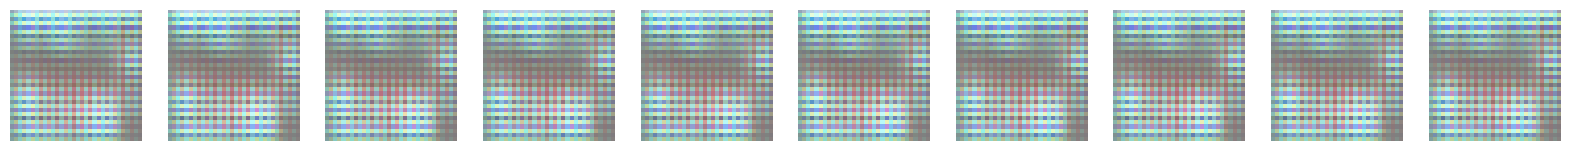

1/1 [==============================] - 0s 30ms/step
651 [D loss: 0.074986, acc.: 98.44%] [G loss: 3.232647]
1/1 [==============================] - 0s 33ms/step
652 [D loss: 0.062238, acc.: 98.44%] [G loss: 3.162311]
1/1 [==============================] - 0s 33ms/step
653 [D loss: 0.056614, acc.: 98.44%] [G loss: 3.090151]
1/1 [==============================] - 0s 39ms/step
654 [D loss: 0.062575, acc.: 98.44%] [G loss: 3.076266]
1/1 [==============================] - 0s 29ms/step
655 [D loss: 0.030875, acc.: 100.00%] [G loss: 3.278032]
1/1 [==============================] - 0s 31ms/step
656 [D loss: 0.087371, acc.: 96.88%] [G loss: 3.116188]
1/1 [==============================] - 0s 35ms/step
657 [D loss: 0.041159, acc.: 100.00%] [G loss: 3.057747]
1/1 [==============================] - 0s 52ms/step
658 [D loss: 0.099826, acc.: 96.88%] [G loss: 2.946736]
1/1 [==============================] - 0s 20ms/step
659 [D loss: 0.050036, acc.: 100.00%] [G loss: 2.875578]
1/1 [====================

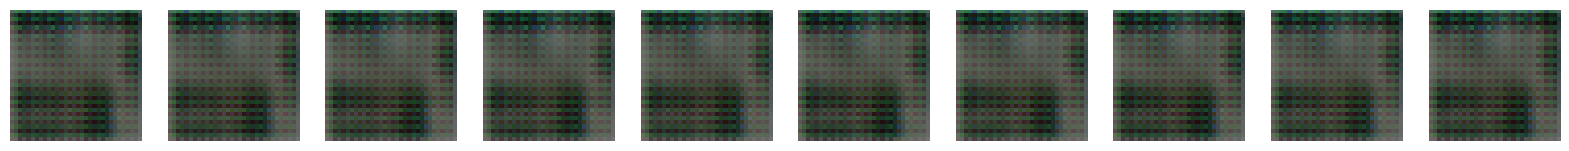

1/1 [==============================] - 0s 20ms/step
701 [D loss: 0.394195, acc.: 85.94%] [G loss: 2.695133]
1/1 [==============================] - 0s 19ms/step
702 [D loss: 0.354954, acc.: 87.50%] [G loss: 2.260653]
1/1 [==============================] - 0s 19ms/step
703 [D loss: 0.246800, acc.: 92.19%] [G loss: 2.757503]
1/1 [==============================] - 0s 18ms/step
704 [D loss: 0.257315, acc.: 92.19%] [G loss: 2.668879]
1/1 [==============================] - 0s 20ms/step
705 [D loss: 0.381072, acc.: 90.62%] [G loss: 2.432273]
1/1 [==============================] - 0s 19ms/step
706 [D loss: 0.363505, acc.: 89.06%] [G loss: 2.645214]
1/1 [==============================] - 0s 19ms/step
707 [D loss: 0.328688, acc.: 87.50%] [G loss: 2.535630]
1/1 [==============================] - 0s 22ms/step
708 [D loss: 0.271613, acc.: 90.62%] [G loss: 2.631806]
1/1 [==============================] - 0s 24ms/step
709 [D loss: 0.265913, acc.: 90.62%] [G loss: 2.567021]
1/1 [=======================

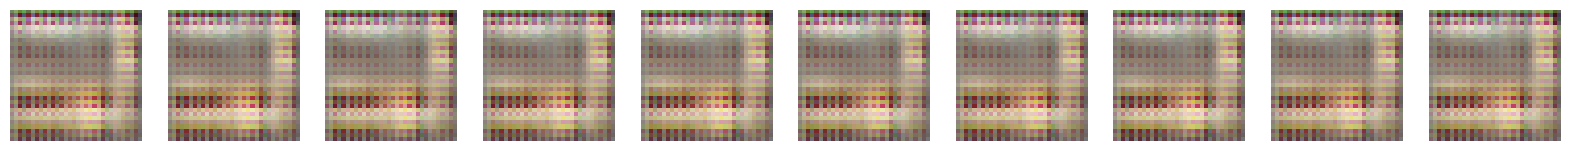

1/1 [==============================] - 0s 19ms/step
751 [D loss: 0.362687, acc.: 92.19%] [G loss: 1.869658]
1/1 [==============================] - 0s 19ms/step
752 [D loss: 0.336345, acc.: 92.19%] [G loss: 2.158998]
1/1 [==============================] - 0s 25ms/step
753 [D loss: 0.217295, acc.: 96.88%] [G loss: 2.592751]
1/1 [==============================] - 0s 18ms/step
754 [D loss: 0.143994, acc.: 96.88%] [G loss: 2.905766]
1/1 [==============================] - 0s 18ms/step
755 [D loss: 0.145286, acc.: 96.88%] [G loss: 3.100113]
1/1 [==============================] - 0s 20ms/step
756 [D loss: 0.118000, acc.: 98.44%] [G loss: 3.406308]
1/1 [==============================] - 0s 18ms/step
757 [D loss: 0.096598, acc.: 96.88%] [G loss: 3.579932]
1/1 [==============================] - 0s 17ms/step
758 [D loss: 0.111587, acc.: 96.88%] [G loss: 3.898523]
1/1 [==============================] - 0s 21ms/step
759 [D loss: 0.100047, acc.: 96.88%] [G loss: 3.909333]
1/1 [=======================

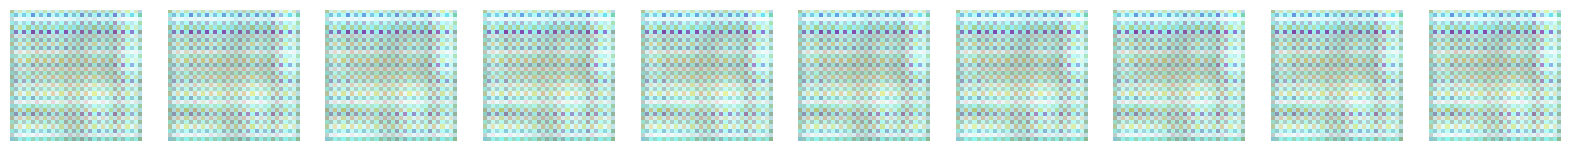

1/1 [==============================] - 0s 24ms/step
801 [D loss: 0.093240, acc.: 98.44%] [G loss: 3.750288]
1/1 [==============================] - 0s 29ms/step
802 [D loss: 0.069221, acc.: 96.88%] [G loss: 4.110592]
1/1 [==============================] - 0s 29ms/step
803 [D loss: 0.092374, acc.: 96.88%] [G loss: 3.775565]
1/1 [==============================] - 0s 20ms/step
804 [D loss: 0.112310, acc.: 96.88%] [G loss: 4.061430]
1/1 [==============================] - 0s 25ms/step
805 [D loss: 0.076053, acc.: 96.88%] [G loss: 4.232148]
1/1 [==============================] - 0s 23ms/step
806 [D loss: 0.012609, acc.: 100.00%] [G loss: 4.636266]
1/1 [==============================] - 0s 21ms/step
807 [D loss: 0.072947, acc.: 96.88%] [G loss: 4.483999]
1/1 [==============================] - 0s 20ms/step
808 [D loss: 0.097672, acc.: 96.88%] [G loss: 4.021368]
1/1 [==============================] - 0s 27ms/step
809 [D loss: 0.218728, acc.: 95.31%] [G loss: 3.346543]
1/1 [======================

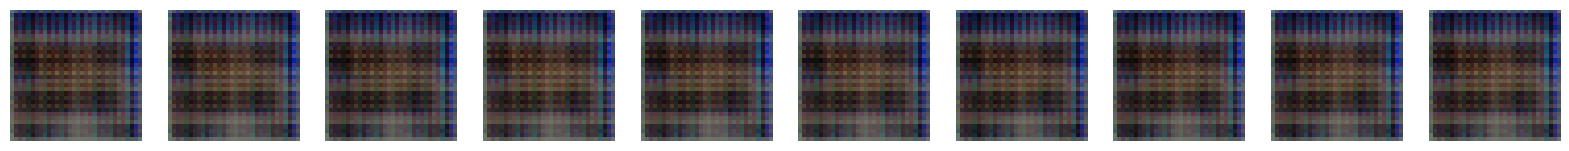

1/1 [==============================] - 0s 23ms/step
851 [D loss: 0.212895, acc.: 95.31%] [G loss: 3.701413]
1/1 [==============================] - 0s 20ms/step
852 [D loss: 0.308724, acc.: 87.50%] [G loss: 3.828695]
1/1 [==============================] - 0s 21ms/step
853 [D loss: 0.524478, acc.: 84.38%] [G loss: 4.227068]
1/1 [==============================] - 0s 22ms/step
854 [D loss: 0.468549, acc.: 82.81%] [G loss: 3.504674]
1/1 [==============================] - 0s 19ms/step
855 [D loss: 0.307818, acc.: 89.06%] [G loss: 3.939165]
1/1 [==============================] - 0s 21ms/step
856 [D loss: 0.463762, acc.: 81.25%] [G loss: 3.465225]
1/1 [==============================] - 0s 27ms/step
857 [D loss: 0.494674, acc.: 82.81%] [G loss: 3.968140]
1/1 [==============================] - 0s 19ms/step
858 [D loss: 0.131311, acc.: 92.19%] [G loss: 4.461518]
1/1 [==============================] - 0s 18ms/step
859 [D loss: 0.281690, acc.: 87.50%] [G loss: 3.124874]
1/1 [=======================

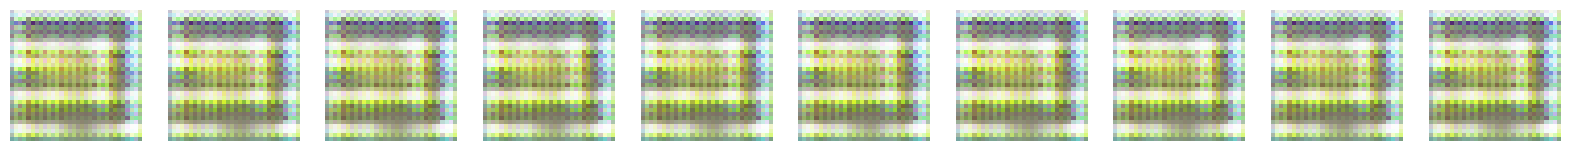

1/1 [==============================] - 0s 20ms/step
901 [D loss: 0.223739, acc.: 95.31%] [G loss: 3.582253]
1/1 [==============================] - 0s 19ms/step
902 [D loss: 0.275231, acc.: 93.75%] [G loss: 3.679405]
1/1 [==============================] - 0s 19ms/step
903 [D loss: 0.406715, acc.: 87.50%] [G loss: 3.671667]
1/1 [==============================] - 0s 19ms/step
904 [D loss: 0.385575, acc.: 92.19%] [G loss: 3.741255]
1/1 [==============================] - 0s 20ms/step
905 [D loss: 0.430656, acc.: 85.94%] [G loss: 3.662027]
1/1 [==============================] - 0s 17ms/step
906 [D loss: 0.291798, acc.: 93.75%] [G loss: 3.526250]
1/1 [==============================] - 0s 21ms/step
907 [D loss: 0.328493, acc.: 90.62%] [G loss: 4.001627]
1/1 [==============================] - 0s 18ms/step
908 [D loss: 0.497973, acc.: 85.94%] [G loss: 3.441467]
1/1 [==============================] - 0s 31ms/step
909 [D loss: 0.353518, acc.: 89.06%] [G loss: 4.212873]
1/1 [=======================

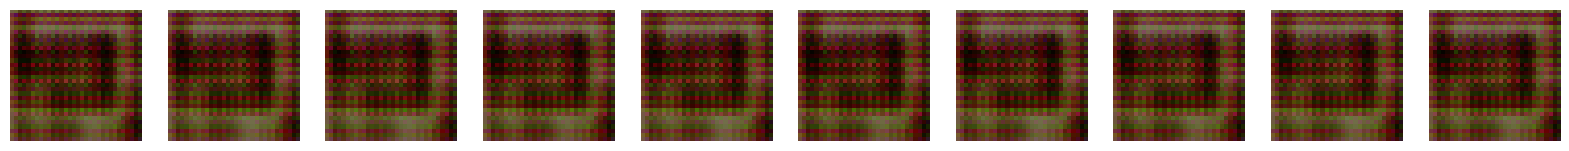

1/1 [==============================] - 0s 18ms/step
951 [D loss: 0.508619, acc.: 87.50%] [G loss: 3.169483]
1/1 [==============================] - 0s 18ms/step
952 [D loss: 0.154482, acc.: 93.75%] [G loss: 3.430068]
1/1 [==============================] - 0s 19ms/step
953 [D loss: 0.197175, acc.: 93.75%] [G loss: 3.638287]
1/1 [==============================] - 0s 18ms/step
954 [D loss: 0.189450, acc.: 89.06%] [G loss: 3.208140]
1/1 [==============================] - 0s 17ms/step
955 [D loss: 0.257919, acc.: 90.62%] [G loss: 3.417548]
1/1 [==============================] - 0s 18ms/step
956 [D loss: 0.291891, acc.: 90.62%] [G loss: 3.284914]
1/1 [==============================] - 0s 18ms/step
957 [D loss: 0.320342, acc.: 87.50%] [G loss: 3.598921]
1/1 [==============================] - 0s 18ms/step
958 [D loss: 0.141817, acc.: 93.75%] [G loss: 3.946720]
1/1 [==============================] - 0s 21ms/step
959 [D loss: 0.251031, acc.: 87.50%] [G loss: 3.214274]
1/1 [=======================

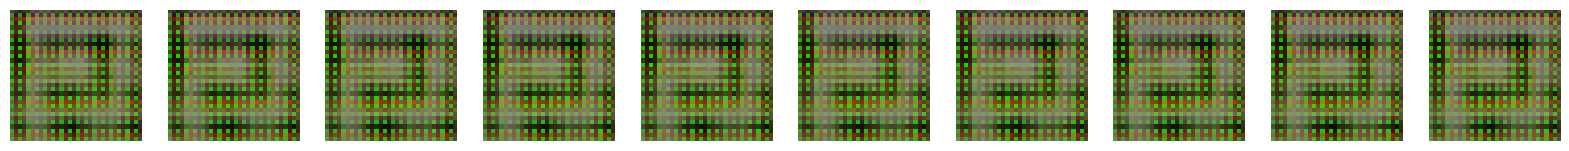

1/1 [==============================] - 0s 39ms/step
1001 [D loss: 0.246809, acc.: 92.19%] [G loss: 2.508748]
1/1 [==============================] - 0s 32ms/step
1002 [D loss: 0.290429, acc.: 90.62%] [G loss: 2.410596]
1/1 [==============================] - 0s 28ms/step
1003 [D loss: 0.116607, acc.: 98.44%] [G loss: 2.673938]
1/1 [==============================] - 0s 29ms/step
1004 [D loss: 0.066420, acc.: 100.00%] [G loss: 2.866985]
1/1 [==============================] - 0s 28ms/step
1005 [D loss: 0.213612, acc.: 92.19%] [G loss: 2.687047]
1/1 [==============================] - 0s 30ms/step
1006 [D loss: 0.277715, acc.: 90.62%] [G loss: 2.361673]
1/1 [==============================] - 0s 27ms/step
1007 [D loss: 0.245575, acc.: 92.19%] [G loss: 2.114033]
1/1 [==============================] - 0s 29ms/step
1008 [D loss: 0.136075, acc.: 96.88%] [G loss: 2.446884]
1/1 [==============================] - 0s 34ms/step
1009 [D loss: 0.166962, acc.: 95.31%] [G loss: 2.333039]
1/1 [=============

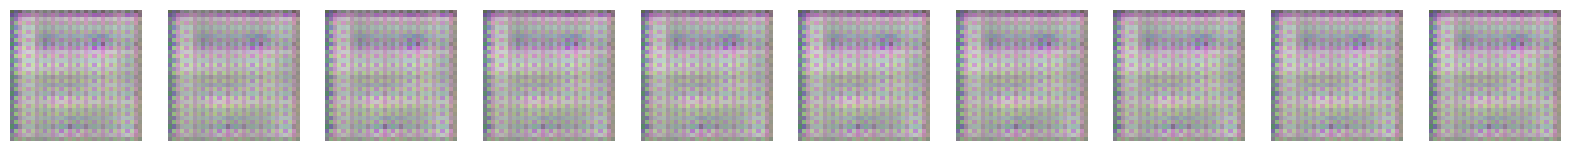

1/1 [==============================] - 0s 25ms/step
1051 [D loss: 0.115061, acc.: 96.88%] [G loss: 2.878831]
1/1 [==============================] - 0s 21ms/step
1052 [D loss: 0.166532, acc.: 95.31%] [G loss: 2.695033]
1/1 [==============================] - 0s 18ms/step
1053 [D loss: 0.139455, acc.: 95.31%] [G loss: 2.731835]
1/1 [==============================] - 0s 17ms/step
1054 [D loss: 0.139837, acc.: 95.31%] [G loss: 2.825399]
1/1 [==============================] - 0s 17ms/step
1055 [D loss: 0.058843, acc.: 98.44%] [G loss: 3.101661]
1/1 [==============================] - 0s 18ms/step
1056 [D loss: 0.091336, acc.: 95.31%] [G loss: 3.194272]
1/1 [==============================] - 0s 17ms/step
1057 [D loss: 0.193606, acc.: 89.06%] [G loss: 2.616341]
1/1 [==============================] - 0s 19ms/step
1058 [D loss: 0.232679, acc.: 92.19%] [G loss: 2.578877]
1/1 [==============================] - 0s 17ms/step
1059 [D loss: 0.171639, acc.: 93.75%] [G loss: 2.810900]
1/1 [==============

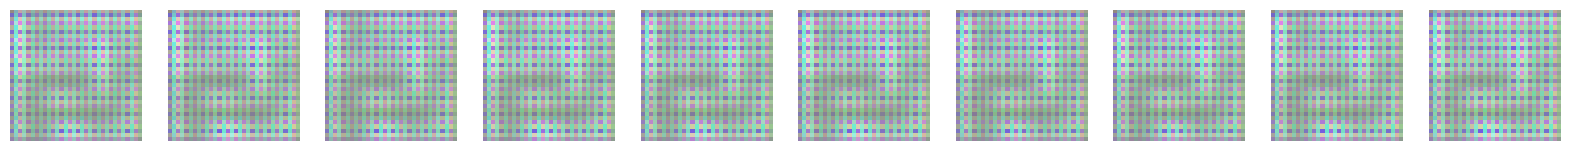

1/1 [==============================] - 0s 35ms/step
1101 [D loss: 0.103165, acc.: 96.88%] [G loss: 3.031085]
1/1 [==============================] - 0s 43ms/step
1102 [D loss: 0.141037, acc.: 96.88%] [G loss: 2.919214]
1/1 [==============================] - 0s 29ms/step
1103 [D loss: 0.053477, acc.: 100.00%] [G loss: 3.098926]
1/1 [==============================] - 0s 35ms/step
1104 [D loss: 0.074747, acc.: 98.44%] [G loss: 3.007125]
1/1 [==============================] - 0s 32ms/step
1105 [D loss: 0.070632, acc.: 98.44%] [G loss: 3.142816]
1/1 [==============================] - 0s 35ms/step
1106 [D loss: 0.050533, acc.: 98.44%] [G loss: 3.285137]
1/1 [==============================] - 0s 37ms/step
1107 [D loss: 0.043785, acc.: 96.88%] [G loss: 3.486355]
1/1 [==============================] - 0s 31ms/step
1108 [D loss: 0.131563, acc.: 95.31%] [G loss: 2.954310]
1/1 [==============================] - 0s 34ms/step
1109 [D loss: 0.112192, acc.: 98.44%] [G loss: 2.823781]
1/1 [=============

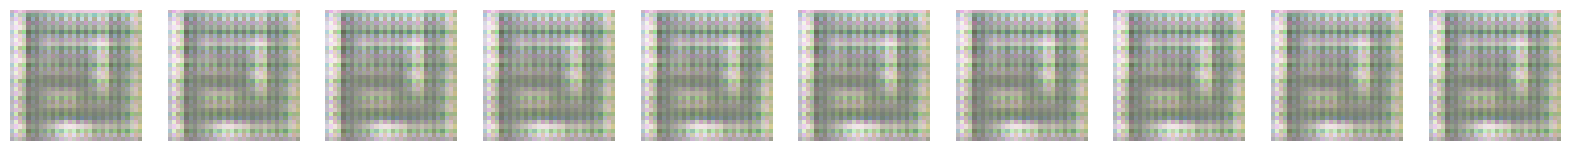

1/1 [==============================] - 0s 24ms/step
1151 [D loss: 0.109234, acc.: 96.88%] [G loss: 2.998760]
1/1 [==============================] - 0s 19ms/step
1152 [D loss: 0.063719, acc.: 98.44%] [G loss: 3.053893]
1/1 [==============================] - 0s 20ms/step
1153 [D loss: 0.038333, acc.: 100.00%] [G loss: 3.095291]
1/1 [==============================] - 0s 19ms/step
1154 [D loss: 0.139413, acc.: 96.88%] [G loss: 2.956452]
1/1 [==============================] - 0s 24ms/step
1155 [D loss: 0.200713, acc.: 92.19%] [G loss: 2.598712]
1/1 [==============================] - 0s 19ms/step
1156 [D loss: 0.078691, acc.: 98.44%] [G loss: 2.610384]
1/1 [==============================] - 0s 19ms/step
1157 [D loss: 0.087994, acc.: 98.44%] [G loss: 2.816620]
1/1 [==============================] - 0s 26ms/step
1158 [D loss: 0.139174, acc.: 96.88%] [G loss: 2.953339]
1/1 [==============================] - 0s 21ms/step
1159 [D loss: 0.105750, acc.: 96.88%] [G loss: 2.795076]
1/1 [=============

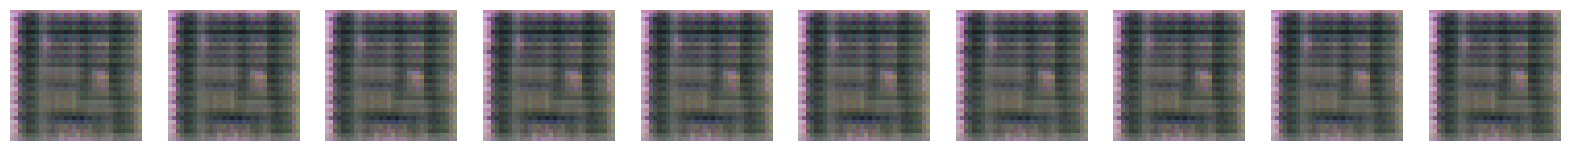

1/1 [==============================] - 0s 29ms/step
1201 [D loss: 0.231486, acc.: 92.19%] [G loss: 2.722194]
1/1 [==============================] - 0s 31ms/step
1202 [D loss: 0.142671, acc.: 96.88%] [G loss: 2.929373]
1/1 [==============================] - 0s 28ms/step
1203 [D loss: 0.119793, acc.: 98.44%] [G loss: 2.982468]
1/1 [==============================] - 0s 25ms/step
1204 [D loss: 0.162565, acc.: 96.88%] [G loss: 2.993793]
1/1 [==============================] - 0s 27ms/step
1205 [D loss: 0.332406, acc.: 90.62%] [G loss: 2.751109]
1/1 [==============================] - 0s 18ms/step
1206 [D loss: 0.161406, acc.: 95.31%] [G loss: 3.143425]
1/1 [==============================] - 0s 18ms/step
1207 [D loss: 0.412990, acc.: 87.50%] [G loss: 2.842276]
1/1 [==============================] - 0s 19ms/step
1208 [D loss: 0.305382, acc.: 92.19%] [G loss: 3.224839]
1/1 [==============================] - 0s 19ms/step
1209 [D loss: 0.327758, acc.: 84.38%] [G loss: 3.143491]
1/1 [==============

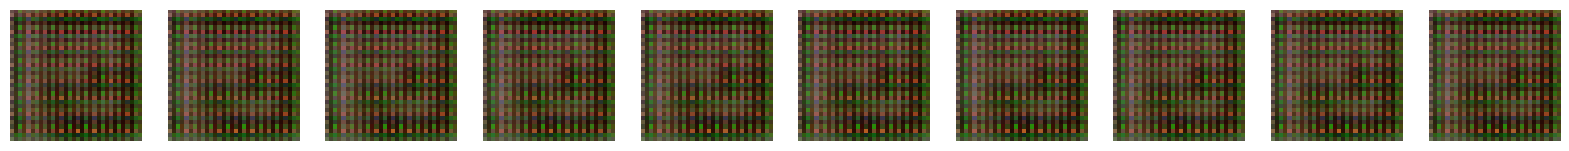

1/1 [==============================] - 0s 19ms/step
1251 [D loss: 0.442504, acc.: 85.94%] [G loss: 2.964946]
1/1 [==============================] - 0s 18ms/step
1252 [D loss: 0.321911, acc.: 90.62%] [G loss: 2.949100]
1/1 [==============================] - 0s 17ms/step
1253 [D loss: 0.196811, acc.: 95.31%] [G loss: 3.264484]
1/1 [==============================] - 0s 17ms/step
1254 [D loss: 0.173097, acc.: 93.75%] [G loss: 3.218959]
1/1 [==============================] - 0s 19ms/step
1255 [D loss: 0.347513, acc.: 89.06%] [G loss: 2.516663]
1/1 [==============================] - 0s 18ms/step
1256 [D loss: 0.143462, acc.: 96.88%] [G loss: 3.158127]
1/1 [==============================] - 0s 18ms/step
1257 [D loss: 0.107873, acc.: 98.44%] [G loss: 3.487176]
1/1 [==============================] - 0s 17ms/step
1258 [D loss: 0.248701, acc.: 90.62%] [G loss: 2.894400]
1/1 [==============================] - 0s 19ms/step
1259 [D loss: 0.125842, acc.: 98.44%] [G loss: 3.158163]
1/1 [==============

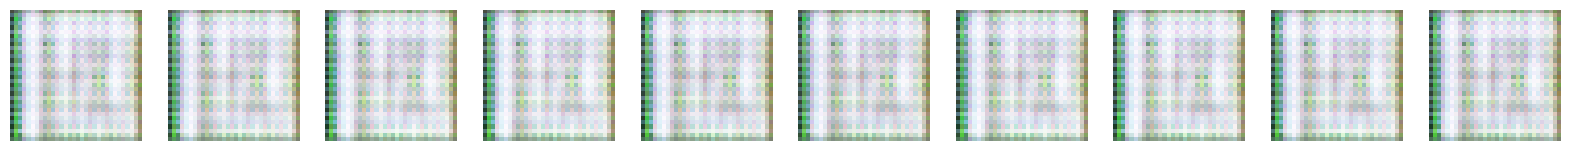

1/1 [==============================] - 0s 25ms/step
1301 [D loss: 0.207732, acc.: 90.62%] [G loss: 4.685533]
1/1 [==============================] - 0s 18ms/step
1302 [D loss: 0.291218, acc.: 89.06%] [G loss: 3.929952]
1/1 [==============================] - 0s 18ms/step
1303 [D loss: 0.083884, acc.: 98.44%] [G loss: 4.764644]
1/1 [==============================] - 0s 20ms/step
1304 [D loss: 0.142289, acc.: 93.75%] [G loss: 4.213933]
1/1 [==============================] - 0s 21ms/step
1305 [D loss: 0.155774, acc.: 93.75%] [G loss: 4.582836]
1/1 [==============================] - 0s 22ms/step
1306 [D loss: 0.188707, acc.: 90.62%] [G loss: 3.888835]
1/1 [==============================] - 0s 20ms/step
1307 [D loss: 0.167979, acc.: 93.75%] [G loss: 4.900353]
1/1 [==============================] - 0s 22ms/step
1308 [D loss: 0.164316, acc.: 95.31%] [G loss: 4.581933]
1/1 [==============================] - 0s 31ms/step
1309 [D loss: 0.102669, acc.: 96.88%] [G loss: 4.687502]
1/1 [==============

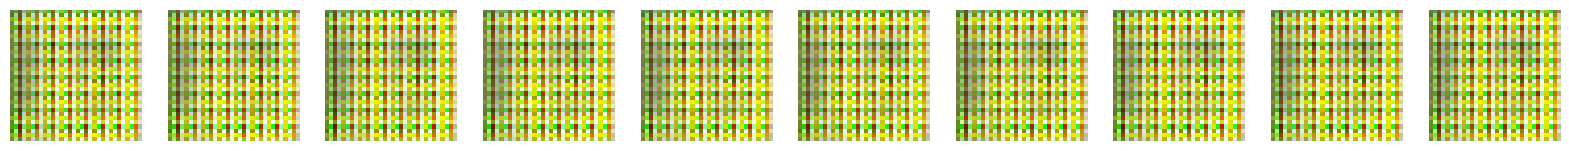

1/1 [==============================] - 0s 39ms/step
1351 [D loss: 0.082232, acc.: 98.44%] [G loss: 3.738587]
1/1 [==============================] - 0s 34ms/step
1352 [D loss: 0.103768, acc.: 98.44%] [G loss: 3.677779]
1/1 [==============================] - 0s 43ms/step
1353 [D loss: 0.056509, acc.: 100.00%] [G loss: 3.624279]
1/1 [==============================] - 0s 30ms/step
1354 [D loss: 0.088691, acc.: 98.44%] [G loss: 3.839308]
1/1 [==============================] - 0s 41ms/step
1355 [D loss: 0.137948, acc.: 96.88%] [G loss: 3.751726]
1/1 [==============================] - 0s 28ms/step
1356 [D loss: 0.222414, acc.: 93.75%] [G loss: 4.176267]
1/1 [==============================] - 0s 32ms/step
1357 [D loss: 0.077314, acc.: 98.44%] [G loss: 4.231011]
1/1 [==============================] - 0s 30ms/step
1358 [D loss: 0.094842, acc.: 98.44%] [G loss: 4.140360]
1/1 [==============================] - 0s 30ms/step
1359 [D loss: 0.079696, acc.: 100.00%] [G loss: 4.535198]
1/1 [============

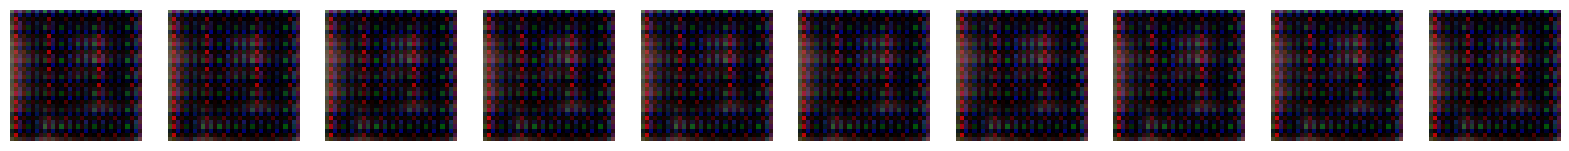

1/1 [==============================] - 0s 19ms/step
1401 [D loss: 0.103567, acc.: 96.88%] [G loss: 4.186375]
1/1 [==============================] - 0s 21ms/step
1402 [D loss: 0.124553, acc.: 93.75%] [G loss: 4.272361]
1/1 [==============================] - 0s 18ms/step
1403 [D loss: 0.246807, acc.: 90.62%] [G loss: 4.124169]
1/1 [==============================] - 0s 19ms/step
1404 [D loss: 0.170116, acc.: 92.19%] [G loss: 3.860258]
1/1 [==============================] - 0s 24ms/step
1405 [D loss: 0.102462, acc.: 95.31%] [G loss: 4.123884]
1/1 [==============================] - 0s 21ms/step
1406 [D loss: 0.354357, acc.: 87.50%] [G loss: 4.509846]
1/1 [==============================] - 0s 22ms/step
1407 [D loss: 0.095900, acc.: 95.31%] [G loss: 5.039113]
1/1 [==============================] - 0s 22ms/step
1408 [D loss: 0.149458, acc.: 93.75%] [G loss: 3.882731]
1/1 [==============================] - 0s 30ms/step
1409 [D loss: 0.092135, acc.: 96.88%] [G loss: 3.993448]
1/1 [==============

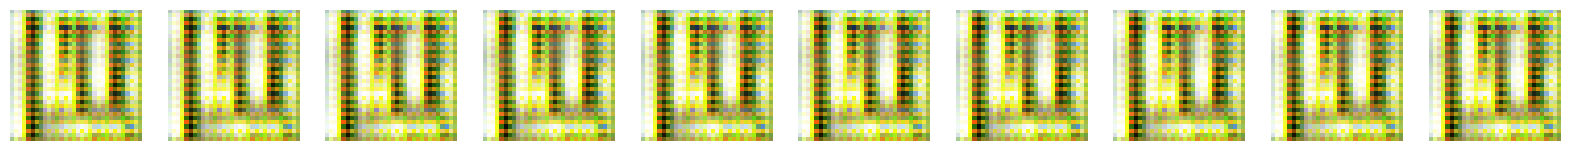

1/1 [==============================] - 0s 29ms/step
1451 [D loss: 0.083272, acc.: 100.00%] [G loss: 3.763210]
1/1 [==============================] - 0s 42ms/step
1452 [D loss: 0.204936, acc.: 95.31%] [G loss: 3.577690]
1/1 [==============================] - 0s 29ms/step
1453 [D loss: 0.157155, acc.: 98.44%] [G loss: 3.726953]
1/1 [==============================] - 0s 33ms/step
1454 [D loss: 0.090681, acc.: 100.00%] [G loss: 3.724928]
1/1 [==============================] - 0s 29ms/step
1455 [D loss: 0.235415, acc.: 92.19%] [G loss: 4.319735]
1/1 [==============================] - 0s 39ms/step
1456 [D loss: 0.289639, acc.: 92.19%] [G loss: 3.939723]
1/1 [==============================] - 0s 29ms/step
1457 [D loss: 0.145443, acc.: 98.44%] [G loss: 3.693561]
1/1 [==============================] - 0s 50ms/step
1458 [D loss: 0.257009, acc.: 95.31%] [G loss: 3.915428]
1/1 [==============================] - 0s 30ms/step
1459 [D loss: 0.201164, acc.: 93.75%] [G loss: 4.042572]
1/1 [============

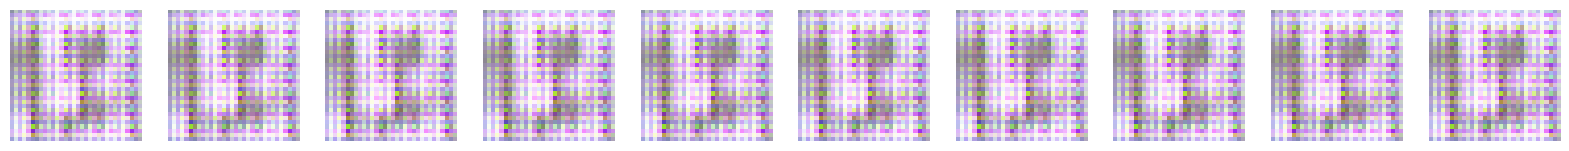

1/1 [==============================] - 0s 19ms/step
1501 [D loss: 0.138758, acc.: 96.88%] [G loss: 3.918245]
1/1 [==============================] - 0s 20ms/step
1502 [D loss: 0.160667, acc.: 96.88%] [G loss: 4.071923]
1/1 [==============================] - 0s 20ms/step
1503 [D loss: 0.033953, acc.: 98.44%] [G loss: 4.387925]
1/1 [==============================] - 0s 20ms/step
1504 [D loss: 0.396575, acc.: 87.50%] [G loss: 3.575188]
1/1 [==============================] - 0s 22ms/step
1505 [D loss: 0.108152, acc.: 96.88%] [G loss: 4.181343]
1/1 [==============================] - 0s 30ms/step
1506 [D loss: 0.185132, acc.: 95.31%] [G loss: 3.551169]
1/1 [==============================] - 0s 25ms/step
1507 [D loss: 0.151264, acc.: 95.31%] [G loss: 3.481542]
1/1 [==============================] - 0s 30ms/step
1508 [D loss: 0.277824, acc.: 95.31%] [G loss: 3.236396]
1/1 [==============================] - 0s 19ms/step
1509 [D loss: 0.165518, acc.: 95.31%] [G loss: 3.184296]
1/1 [==============

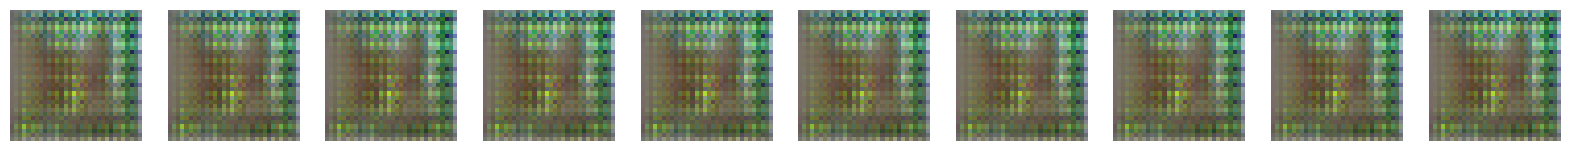

1/1 [==============================] - 0s 33ms/step
1551 [D loss: 0.150413, acc.: 98.44%] [G loss: 2.151325]
1/1 [==============================] - 0s 23ms/step
1552 [D loss: 0.191643, acc.: 96.88%] [G loss: 2.236890]
1/1 [==============================] - 0s 22ms/step
1553 [D loss: 0.230196, acc.: 95.31%] [G loss: 2.367072]
1/1 [==============================] - 0s 30ms/step
1554 [D loss: 0.206892, acc.: 93.75%] [G loss: 2.463435]
1/1 [==============================] - 0s 32ms/step
1555 [D loss: 0.228968, acc.: 93.75%] [G loss: 2.363475]
1/1 [==============================] - 0s 29ms/step
1556 [D loss: 0.189550, acc.: 96.88%] [G loss: 2.446231]
1/1 [==============================] - 0s 28ms/step
1557 [D loss: 0.220494, acc.: 93.75%] [G loss: 2.498007]
1/1 [==============================] - 0s 32ms/step
1558 [D loss: 0.217763, acc.: 95.31%] [G loss: 2.429269]
1/1 [==============================] - 0s 24ms/step
1559 [D loss: 0.349190, acc.: 89.06%] [G loss: 2.132086]
1/1 [==============

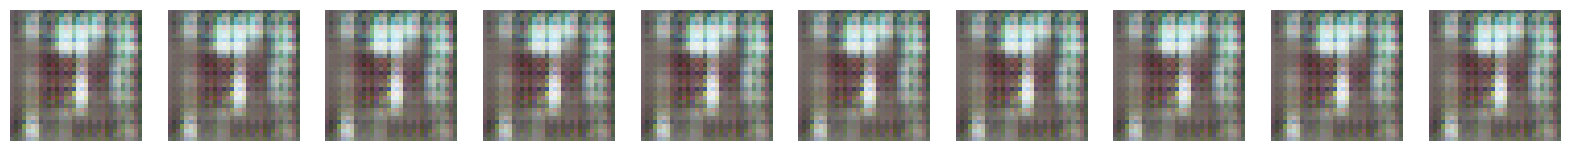

1/1 [==============================] - 0s 21ms/step
1601 [D loss: 0.128201, acc.: 98.44%] [G loss: 2.155012]
1/1 [==============================] - 0s 27ms/step
1602 [D loss: 0.147027, acc.: 98.44%] [G loss: 2.207838]
1/1 [==============================] - 0s 26ms/step
1603 [D loss: 0.120772, acc.: 98.44%] [G loss: 2.389675]
1/1 [==============================] - 0s 25ms/step
1604 [D loss: 0.113780, acc.: 100.00%] [G loss: 2.486604]
1/1 [==============================] - 0s 21ms/step
1605 [D loss: 0.104277, acc.: 98.44%] [G loss: 2.498548]
1/1 [==============================] - 0s 31ms/step
1606 [D loss: 0.126900, acc.: 96.88%] [G loss: 2.592566]
1/1 [==============================] - 0s 22ms/step
1607 [D loss: 0.119333, acc.: 95.31%] [G loss: 2.678254]
1/1 [==============================] - 0s 21ms/step
1608 [D loss: 0.093877, acc.: 100.00%] [G loss: 2.840236]
1/1 [==============================] - 0s 24ms/step
1609 [D loss: 0.107391, acc.: 96.88%] [G loss: 2.956080]
1/1 [============

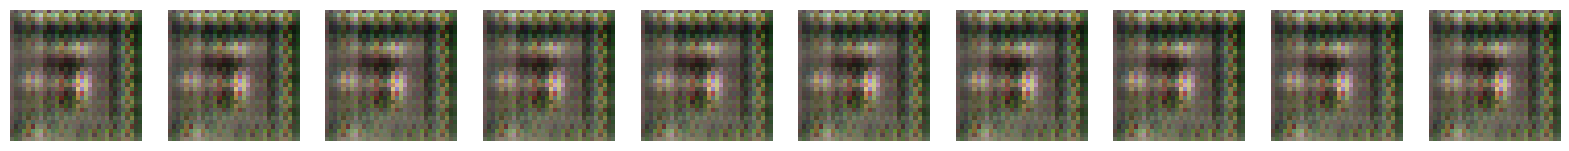

1/1 [==============================] - 0s 20ms/step
1651 [D loss: 0.130244, acc.: 98.44%] [G loss: 2.931195]
1/1 [==============================] - 0s 20ms/step
1652 [D loss: 0.214856, acc.: 93.75%] [G loss: 2.743054]
1/1 [==============================] - 0s 19ms/step
1653 [D loss: 0.295333, acc.: 89.06%] [G loss: 2.444559]
1/1 [==============================] - 0s 27ms/step
1654 [D loss: 0.176569, acc.: 95.31%] [G loss: 2.676702]
1/1 [==============================] - 0s 27ms/step
1655 [D loss: 0.205340, acc.: 92.19%] [G loss: 2.880147]
1/1 [==============================] - 0s 21ms/step
1656 [D loss: 0.265443, acc.: 93.75%] [G loss: 2.658983]
1/1 [==============================] - 0s 25ms/step
1657 [D loss: 0.229312, acc.: 92.19%] [G loss: 2.633287]
1/1 [==============================] - 0s 25ms/step
1658 [D loss: 0.172421, acc.: 96.88%] [G loss: 2.593039]
1/1 [==============================] - 0s 20ms/step
1659 [D loss: 0.254028, acc.: 89.06%] [G loss: 2.390246]
1/1 [==============

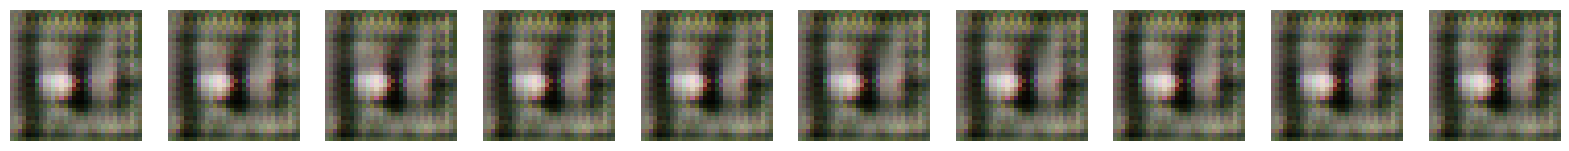

1/1 [==============================] - 0s 23ms/step
1701 [D loss: 0.370964, acc.: 89.06%] [G loss: 2.774413]
1/1 [==============================] - 0s 23ms/step
1702 [D loss: 0.461061, acc.: 89.06%] [G loss: 2.524975]
1/1 [==============================] - 0s 20ms/step
1703 [D loss: 0.328772, acc.: 90.62%] [G loss: 2.816909]
1/1 [==============================] - 0s 33ms/step
1704 [D loss: 0.294423, acc.: 92.19%] [G loss: 2.932303]
1/1 [==============================] - 0s 25ms/step
1705 [D loss: 0.194588, acc.: 92.19%] [G loss: 3.053905]
1/1 [==============================] - 0s 29ms/step
1706 [D loss: 0.395064, acc.: 82.81%] [G loss: 2.939670]
1/1 [==============================] - 0s 27ms/step
1707 [D loss: 0.540420, acc.: 84.38%] [G loss: 3.124299]
1/1 [==============================] - 0s 35ms/step
1708 [D loss: 0.299599, acc.: 87.50%] [G loss: 2.912282]
1/1 [==============================] - 0s 37ms/step
1709 [D loss: 0.239913, acc.: 93.75%] [G loss: 3.440298]
1/1 [==============

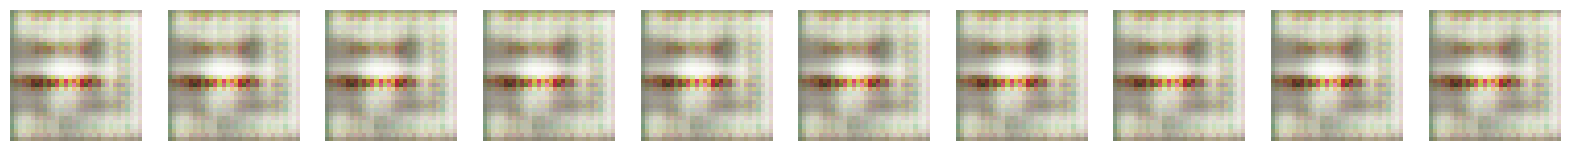

1/1 [==============================] - 0s 20ms/step
1751 [D loss: 0.137305, acc.: 98.44%] [G loss: 3.957486]
1/1 [==============================] - 0s 19ms/step
1752 [D loss: 0.094722, acc.: 95.31%] [G loss: 4.133015]
1/1 [==============================] - 0s 19ms/step
1753 [D loss: 0.282612, acc.: 92.19%] [G loss: 3.553194]
1/1 [==============================] - 0s 19ms/step
1754 [D loss: 0.293850, acc.: 93.75%] [G loss: 3.839786]
1/1 [==============================] - 0s 19ms/step
1755 [D loss: 0.174451, acc.: 92.19%] [G loss: 3.943030]
1/1 [==============================] - 0s 19ms/step
1756 [D loss: 0.154015, acc.: 93.75%] [G loss: 3.652971]
1/1 [==============================] - 0s 25ms/step
1757 [D loss: 0.251978, acc.: 90.62%] [G loss: 3.334290]
1/1 [==============================] - 0s 17ms/step
1758 [D loss: 0.199860, acc.: 95.31%] [G loss: 3.635165]
1/1 [==============================] - 0s 18ms/step
1759 [D loss: 0.210988, acc.: 96.88%] [G loss: 3.575290]
1/1 [==============

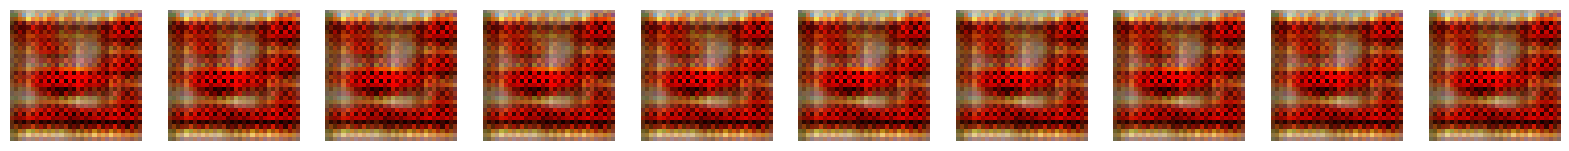

1/1 [==============================] - 0s 28ms/step
1801 [D loss: 0.932118, acc.: 70.31%] [G loss: 3.272047]
1/1 [==============================] - 0s 29ms/step
1802 [D loss: 0.237397, acc.: 95.31%] [G loss: 3.746989]
1/1 [==============================] - 0s 32ms/step
1803 [D loss: 0.456457, acc.: 82.81%] [G loss: 2.975851]
1/1 [==============================] - 0s 31ms/step
1804 [D loss: 0.294075, acc.: 89.06%] [G loss: 3.498264]
1/1 [==============================] - 0s 29ms/step
1805 [D loss: 0.177540, acc.: 93.75%] [G loss: 3.555886]
1/1 [==============================] - 0s 41ms/step
1806 [D loss: 0.194929, acc.: 92.19%] [G loss: 3.497742]
1/1 [==============================] - 0s 32ms/step
1807 [D loss: 0.200238, acc.: 95.31%] [G loss: 3.429409]
1/1 [==============================] - 0s 32ms/step
1808 [D loss: 0.257214, acc.: 90.62%] [G loss: 3.796450]
1/1 [==============================] - 0s 33ms/step
1809 [D loss: 0.129578, acc.: 95.31%] [G loss: 3.525546]
1/1 [==============

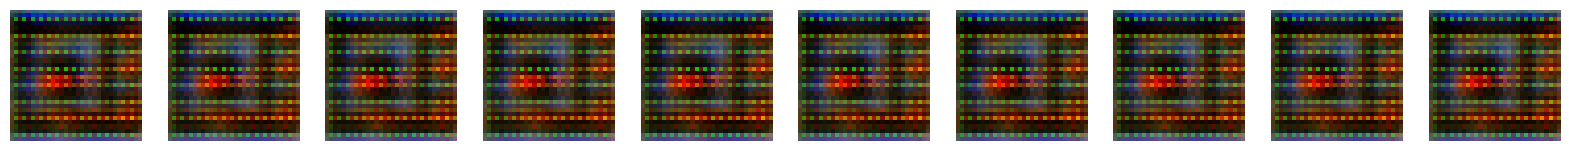

1/1 [==============================] - 0s 20ms/step
1851 [D loss: 1.117361, acc.: 76.56%] [G loss: 9.370806]
1/1 [==============================] - 0s 19ms/step
1852 [D loss: 0.958514, acc.: 78.12%] [G loss: 4.991411]
1/1 [==============================] - 0s 21ms/step
1853 [D loss: 1.135598, acc.: 78.12%] [G loss: 2.952384]
1/1 [==============================] - 0s 20ms/step
1854 [D loss: 1.122587, acc.: 70.31%] [G loss: 3.173812]
1/1 [==============================] - 0s 26ms/step
1855 [D loss: 0.589630, acc.: 85.94%] [G loss: 3.159441]
1/1 [==============================] - 0s 27ms/step
1856 [D loss: 0.347150, acc.: 87.50%] [G loss: 3.141967]
1/1 [==============================] - 0s 22ms/step
1857 [D loss: 0.577978, acc.: 87.50%] [G loss: 3.288434]
1/1 [==============================] - 0s 20ms/step
1858 [D loss: 0.364921, acc.: 87.50%] [G loss: 3.136461]
1/1 [==============================] - 0s 20ms/step
1859 [D loss: 0.350608, acc.: 87.50%] [G loss: 3.081551]
1/1 [==============

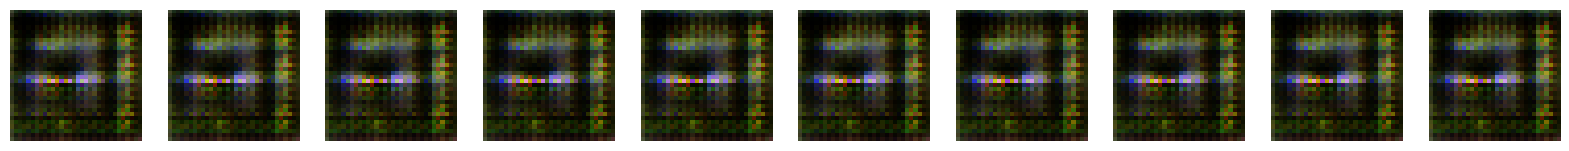

1/1 [==============================] - 0s 33ms/step
1901 [D loss: 0.153855, acc.: 93.75%] [G loss: 3.618662]
1/1 [==============================] - 0s 27ms/step
1902 [D loss: 0.233480, acc.: 87.50%] [G loss: 3.455656]
1/1 [==============================] - 0s 39ms/step
1903 [D loss: 0.372555, acc.: 85.94%] [G loss: 3.171639]
1/1 [==============================] - 0s 34ms/step
1904 [D loss: 0.263342, acc.: 90.62%] [G loss: 3.263342]
1/1 [==============================] - 0s 30ms/step
1905 [D loss: 0.345114, acc.: 87.50%] [G loss: 3.130835]
1/1 [==============================] - 0s 29ms/step
1906 [D loss: 0.360930, acc.: 87.50%] [G loss: 2.942178]
1/1 [==============================] - 0s 26ms/step
1907 [D loss: 0.169318, acc.: 93.75%] [G loss: 3.264049]
1/1 [==============================] - 0s 18ms/step
1908 [D loss: 0.077178, acc.: 96.88%] [G loss: 3.626472]
1/1 [==============================] - 0s 18ms/step
1909 [D loss: 0.059139, acc.: 98.44%] [G loss: 3.857917]
1/1 [==============

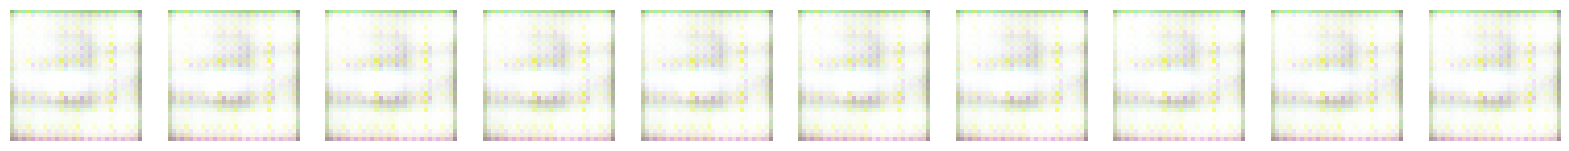

1/1 [==============================] - 0s 19ms/step
1951 [D loss: 0.210086, acc.: 92.19%] [G loss: 9.771204]
1/1 [==============================] - 0s 18ms/step
1952 [D loss: 0.257354, acc.: 93.75%] [G loss: 6.245371]
1/1 [==============================] - 0s 18ms/step
1953 [D loss: 0.221457, acc.: 95.31%] [G loss: 5.340577]
1/1 [==============================] - 0s 17ms/step
1954 [D loss: 0.203732, acc.: 92.19%] [G loss: 5.255321]
1/1 [==============================] - 0s 17ms/step
1955 [D loss: 0.187555, acc.: 90.62%] [G loss: 5.061076]
1/1 [==============================] - 0s 18ms/step
1956 [D loss: 0.222580, acc.: 93.75%] [G loss: 4.517829]
1/1 [==============================] - 0s 17ms/step
1957 [D loss: 0.266602, acc.: 92.19%] [G loss: 5.984521]
1/1 [==============================] - 0s 22ms/step
1958 [D loss: 0.246052, acc.: 93.75%] [G loss: 5.281883]
1/1 [==============================] - 0s 19ms/step
1959 [D loss: 0.164042, acc.: 93.75%] [G loss: 5.519690]
1/1 [==============

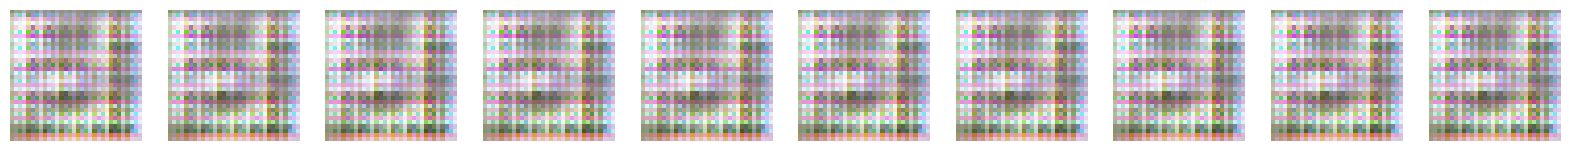

1/1 [==============================] - 0s 26ms/step
2001 [D loss: 0.228674, acc.: 96.88%] [G loss: 3.004788]
1/1 [==============================] - 0s 37ms/step
2002 [D loss: 0.397323, acc.: 93.75%] [G loss: 2.535274]
1/1 [==============================] - 0s 25ms/step
2003 [D loss: 0.211201, acc.: 93.75%] [G loss: 2.674202]
1/1 [==============================] - 0s 24ms/step
2004 [D loss: 0.361722, acc.: 93.75%] [G loss: 2.400108]
1/1 [==============================] - 0s 17ms/step
2005 [D loss: 0.612029, acc.: 87.50%] [G loss: 1.781066]
1/1 [==============================] - 0s 19ms/step
2006 [D loss: 0.210630, acc.: 98.44%] [G loss: 2.160533]
1/1 [==============================] - 0s 23ms/step
2007 [D loss: 0.772395, acc.: 82.81%] [G loss: 1.753359]
1/1 [==============================] - 0s 16ms/step
2008 [D loss: 0.400062, acc.: 93.75%] [G loss: 1.771017]
1/1 [==============================] - 0s 17ms/step
2009 [D loss: 0.739616, acc.: 82.81%] [G loss: 1.522799]
1/1 [==============

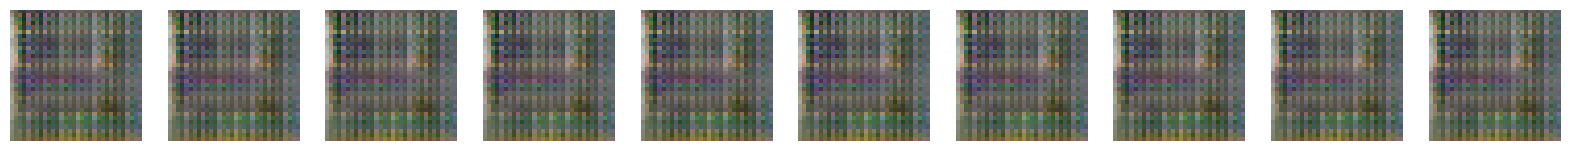

1/1 [==============================] - 0s 17ms/step
2051 [D loss: 0.316225, acc.: 87.50%] [G loss: 1.615271]
1/1 [==============================] - 0s 19ms/step
2052 [D loss: 0.205639, acc.: 95.31%] [G loss: 1.913219]
1/1 [==============================] - 0s 17ms/step
2053 [D loss: 0.226168, acc.: 95.31%] [G loss: 1.932364]
1/1 [==============================] - 0s 24ms/step
2054 [D loss: 0.248375, acc.: 93.75%] [G loss: 1.791374]
1/1 [==============================] - 0s 17ms/step
2055 [D loss: 0.240692, acc.: 93.75%] [G loss: 1.744552]
1/1 [==============================] - 0s 19ms/step
2056 [D loss: 0.320302, acc.: 85.94%] [G loss: 1.606436]
1/1 [==============================] - 0s 24ms/step
2057 [D loss: 0.251294, acc.: 96.88%] [G loss: 1.620652]
1/1 [==============================] - 0s 24ms/step
2058 [D loss: 0.219241, acc.: 96.88%] [G loss: 1.798615]
1/1 [==============================] - 0s 18ms/step
2059 [D loss: 0.262225, acc.: 93.75%] [G loss: 1.707346]
1/1 [==============

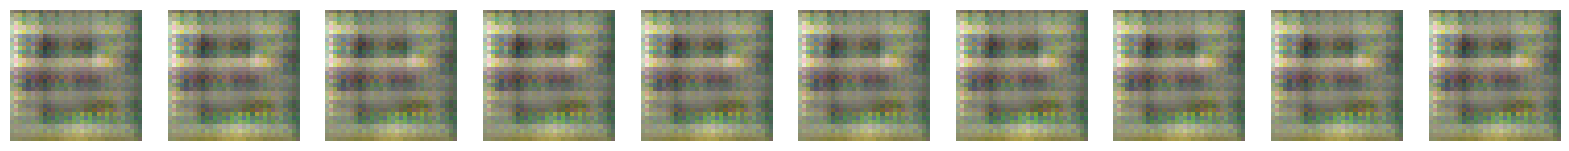

1/1 [==============================] - 0s 19ms/step
2101 [D loss: 0.173319, acc.: 98.44%] [G loss: 1.642406]
1/1 [==============================] - 0s 19ms/step
2102 [D loss: 0.212884, acc.: 98.44%] [G loss: 1.717582]
1/1 [==============================] - 0s 26ms/step
2103 [D loss: 0.221063, acc.: 98.44%] [G loss: 1.591331]
1/1 [==============================] - 0s 27ms/step
2104 [D loss: 0.176276, acc.: 100.00%] [G loss: 1.638600]
1/1 [==============================] - 0s 19ms/step
2105 [D loss: 0.322944, acc.: 90.62%] [G loss: 1.564672]
1/1 [==============================] - 0s 19ms/step
2106 [D loss: 0.250798, acc.: 98.44%] [G loss: 1.610788]
1/1 [==============================] - 0s 19ms/step
2107 [D loss: 0.219230, acc.: 96.88%] [G loss: 1.784502]
1/1 [==============================] - 0s 19ms/step
2108 [D loss: 0.218551, acc.: 96.88%] [G loss: 1.812878]
1/1 [==============================] - 0s 19ms/step
2109 [D loss: 0.195276, acc.: 96.88%] [G loss: 2.052698]
1/1 [=============

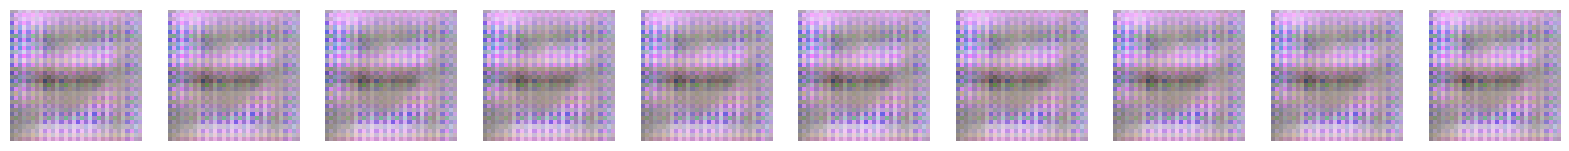

1/1 [==============================] - 0s 23ms/step
2151 [D loss: 0.197474, acc.: 92.19%] [G loss: 2.497103]
1/1 [==============================] - 0s 18ms/step
2152 [D loss: 0.350002, acc.: 90.62%] [G loss: 2.204286]
1/1 [==============================] - 0s 17ms/step
2153 [D loss: 0.253529, acc.: 95.31%] [G loss: 2.337264]
1/1 [==============================] - 0s 22ms/step
2154 [D loss: 0.260311, acc.: 95.31%] [G loss: 2.347775]
1/1 [==============================] - 0s 18ms/step
2155 [D loss: 0.132719, acc.: 98.44%] [G loss: 2.639035]
1/1 [==============================] - 0s 18ms/step
2156 [D loss: 0.198964, acc.: 96.88%] [G loss: 2.586799]
1/1 [==============================] - 0s 18ms/step
2157 [D loss: 0.260382, acc.: 93.75%] [G loss: 2.368972]
1/1 [==============================] - 0s 21ms/step
2158 [D loss: 0.341194, acc.: 90.62%] [G loss: 2.019484]
1/1 [==============================] - 0s 18ms/step
2159 [D loss: 0.275083, acc.: 90.62%] [G loss: 1.987823]
1/1 [==============

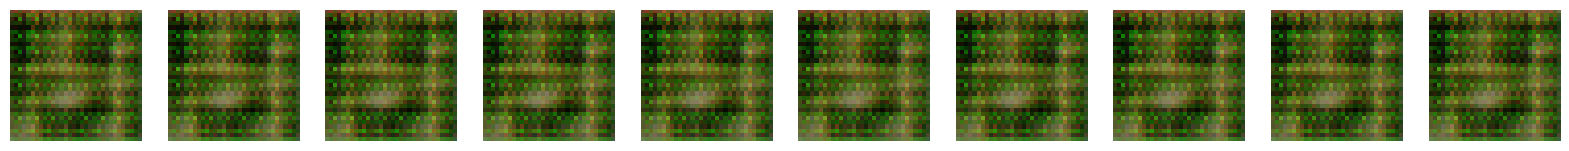

1/1 [==============================] - 0s 20ms/step
2201 [D loss: 0.318474, acc.: 90.62%] [G loss: 3.131272]
1/1 [==============================] - 0s 18ms/step
2202 [D loss: 0.511184, acc.: 85.94%] [G loss: 3.007148]
1/1 [==============================] - 0s 18ms/step
2203 [D loss: 0.343883, acc.: 89.06%] [G loss: 2.959479]
1/1 [==============================] - 0s 18ms/step
2204 [D loss: 0.394490, acc.: 84.38%] [G loss: 2.478408]
1/1 [==============================] - 0s 21ms/step
2205 [D loss: 0.490047, acc.: 85.94%] [G loss: 2.289612]
1/1 [==============================] - 0s 17ms/step
2206 [D loss: 0.242082, acc.: 93.75%] [G loss: 2.476626]
1/1 [==============================] - 0s 17ms/step
2207 [D loss: 0.353799, acc.: 89.06%] [G loss: 2.348963]
1/1 [==============================] - 0s 17ms/step
2208 [D loss: 0.528596, acc.: 81.25%] [G loss: 2.259274]
1/1 [==============================] - 0s 17ms/step
2209 [D loss: 0.839131, acc.: 64.06%] [G loss: 1.848617]
1/1 [==============

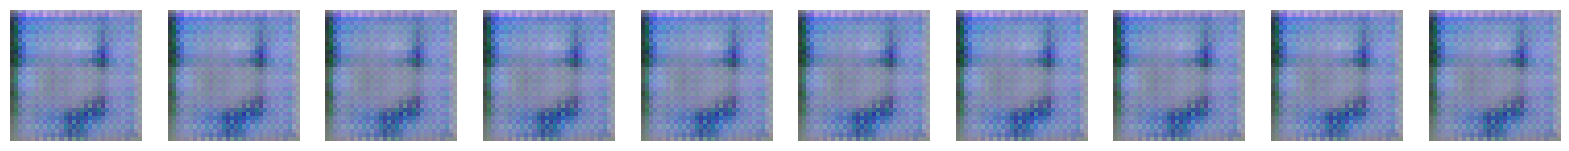

1/1 [==============================] - 0s 20ms/step
2251 [D loss: 0.311169, acc.: 89.06%] [G loss: 1.794175]
1/1 [==============================] - 0s 17ms/step
2252 [D loss: 0.287912, acc.: 93.75%] [G loss: 1.875429]
1/1 [==============================] - 0s 19ms/step
2253 [D loss: 0.232901, acc.: 93.75%] [G loss: 1.941018]
1/1 [==============================] - 0s 20ms/step
2254 [D loss: 0.188191, acc.: 98.44%] [G loss: 1.928467]
1/1 [==============================] - 0s 17ms/step
2255 [D loss: 0.183227, acc.: 100.00%] [G loss: 2.197367]
1/1 [==============================] - 0s 19ms/step
2256 [D loss: 0.256919, acc.: 96.88%] [G loss: 2.177364]
1/1 [==============================] - 0s 21ms/step
2257 [D loss: 0.353191, acc.: 95.31%] [G loss: 2.226164]
1/1 [==============================] - 0s 18ms/step
2258 [D loss: 0.200041, acc.: 98.44%] [G loss: 2.466106]
1/1 [==============================] - 0s 21ms/step
2259 [D loss: 0.246586, acc.: 95.31%] [G loss: 2.527660]
1/1 [=============

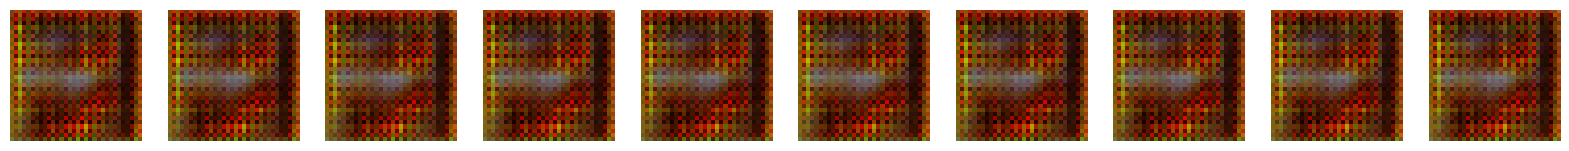

1/1 [==============================] - 0s 23ms/step
2301 [D loss: 0.155865, acc.: 95.31%] [G loss: 3.058739]
1/1 [==============================] - 0s 18ms/step
2302 [D loss: 0.132759, acc.: 93.75%] [G loss: 3.100037]
1/1 [==============================] - 0s 18ms/step
2303 [D loss: 0.282579, acc.: 90.62%] [G loss: 2.625793]
1/1 [==============================] - 0s 18ms/step
2304 [D loss: 0.217953, acc.: 93.75%] [G loss: 3.091183]
1/1 [==============================] - 0s 17ms/step
2305 [D loss: 0.233448, acc.: 92.19%] [G loss: 2.866791]
1/1 [==============================] - 0s 18ms/step
2306 [D loss: 0.332414, acc.: 87.50%] [G loss: 2.847526]
1/1 [==============================] - 0s 17ms/step
2307 [D loss: 0.178803, acc.: 93.75%] [G loss: 3.161497]
1/1 [==============================] - 0s 20ms/step
2308 [D loss: 0.158623, acc.: 96.88%] [G loss: 3.387925]
1/1 [==============================] - 0s 21ms/step
2309 [D loss: 0.147592, acc.: 95.31%] [G loss: 3.159929]
1/1 [==============

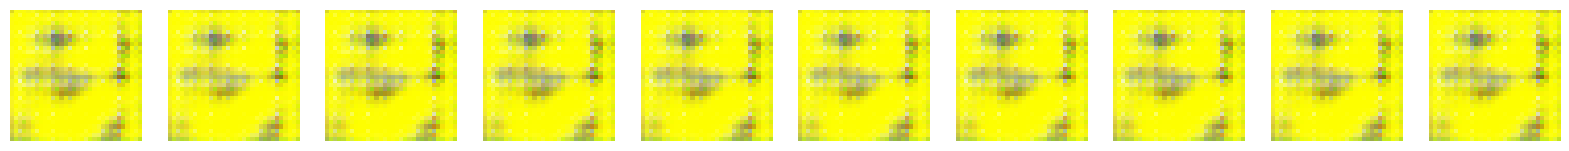

1/1 [==============================] - 0s 34ms/step
2351 [D loss: 0.124891, acc.: 95.31%] [G loss: 5.705613]
1/1 [==============================] - 0s 29ms/step
2352 [D loss: 0.056789, acc.: 98.44%] [G loss: 5.879251]
1/1 [==============================] - 0s 29ms/step
2353 [D loss: 0.167453, acc.: 95.31%] [G loss: 8.974949]
1/1 [==============================] - 0s 31ms/step
2354 [D loss: 0.238731, acc.: 90.62%] [G loss: 6.981953]
1/1 [==============================] - 0s 32ms/step
2355 [D loss: 1.853137, acc.: 46.88%] [G loss: 21.837976]
1/1 [==============================] - 0s 34ms/step
2356 [D loss: 0.454318, acc.: 90.62%] [G loss: 28.889771]
1/1 [==============================] - 0s 31ms/step
2357 [D loss: 1.342945, acc.: 76.56%] [G loss: 20.268238]
1/1 [==============================] - 0s 53ms/step
2358 [D loss: 0.782855, acc.: 73.44%] [G loss: 9.815033]
1/1 [==============================] - 0s 32ms/step
2359 [D loss: 0.305327, acc.: 89.06%] [G loss: 3.601236]
1/1 [===========

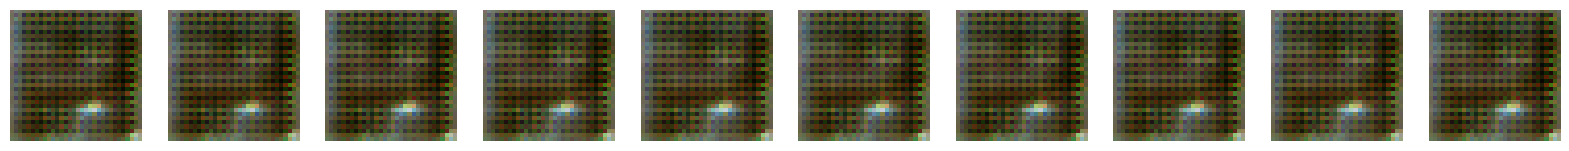

1/1 [==============================] - 0s 19ms/step
2401 [D loss: 0.381655, acc.: 85.94%] [G loss: 2.566852]
1/1 [==============================] - 0s 19ms/step
2402 [D loss: 0.135977, acc.: 96.88%] [G loss: 2.655852]
1/1 [==============================] - 0s 20ms/step
2403 [D loss: 0.201655, acc.: 92.19%] [G loss: 2.611290]
1/1 [==============================] - 0s 18ms/step
2404 [D loss: 0.274809, acc.: 85.94%] [G loss: 2.300234]
1/1 [==============================] - 0s 19ms/step
2405 [D loss: 0.253648, acc.: 90.62%] [G loss: 2.313129]
1/1 [==============================] - 0s 21ms/step
2406 [D loss: 0.201042, acc.: 90.62%] [G loss: 2.433990]
1/1 [==============================] - 0s 28ms/step
2407 [D loss: 0.171633, acc.: 93.75%] [G loss: 2.505169]
1/1 [==============================] - 0s 25ms/step
2408 [D loss: 0.200091, acc.: 92.19%] [G loss: 2.405213]
1/1 [==============================] - 0s 33ms/step
2409 [D loss: 0.206054, acc.: 93.75%] [G loss: 2.428395]
1/1 [==============

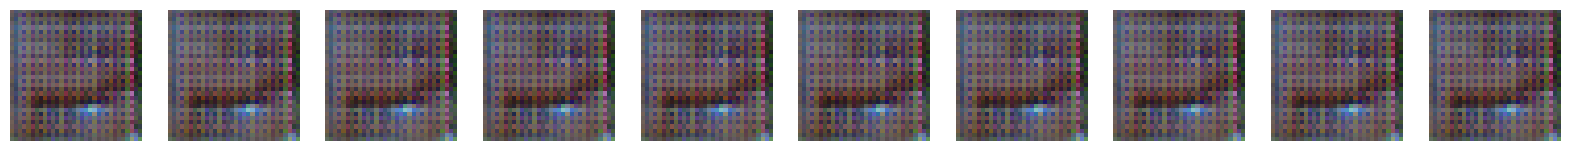

1/1 [==============================] - 0s 36ms/step
2451 [D loss: 0.322385, acc.: 87.50%] [G loss: 2.050628]
1/1 [==============================] - 0s 31ms/step
2452 [D loss: 0.146588, acc.: 98.44%] [G loss: 2.065735]
1/1 [==============================] - 0s 28ms/step
2453 [D loss: 0.175755, acc.: 96.88%] [G loss: 2.062847]
1/1 [==============================] - 0s 42ms/step
2454 [D loss: 0.120108, acc.: 98.44%] [G loss: 2.117144]
1/1 [==============================] - 0s 43ms/step
2455 [D loss: 0.243645, acc.: 95.31%] [G loss: 2.057601]
1/1 [==============================] - 0s 35ms/step
2456 [D loss: 0.278559, acc.: 92.19%] [G loss: 1.951361]
1/1 [==============================] - 0s 35ms/step
2457 [D loss: 0.215577, acc.: 93.75%] [G loss: 1.927368]
1/1 [==============================] - 0s 29ms/step
2458 [D loss: 0.245714, acc.: 90.62%] [G loss: 1.846962]
1/1 [==============================] - 0s 36ms/step
2459 [D loss: 0.295461, acc.: 89.06%] [G loss: 1.838564]
1/1 [==============

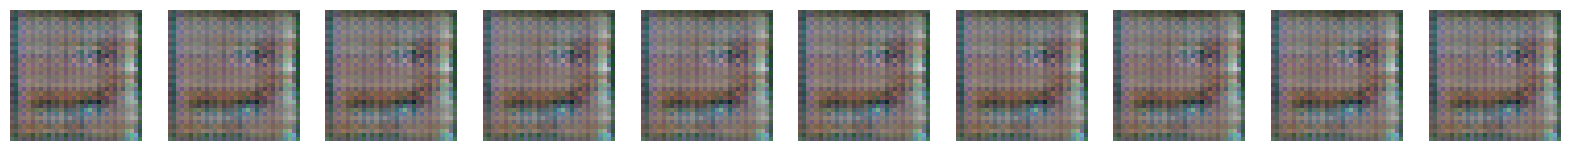

1/1 [==============================] - 0s 25ms/step
2501 [D loss: 0.176438, acc.: 100.00%] [G loss: 1.548052]
1/1 [==============================] - 0s 20ms/step
2502 [D loss: 0.175669, acc.: 96.88%] [G loss: 1.535123]
1/1 [==============================] - 0s 23ms/step
2503 [D loss: 0.193378, acc.: 95.31%] [G loss: 1.519756]
1/1 [==============================] - 0s 29ms/step
2504 [D loss: 0.224182, acc.: 95.31%] [G loss: 1.477732]
1/1 [==============================] - 0s 21ms/step
2505 [D loss: 0.255653, acc.: 95.31%] [G loss: 1.404455]
1/1 [==============================] - 0s 30ms/step
2506 [D loss: 0.200366, acc.: 98.44%] [G loss: 1.327750]
1/1 [==============================] - 0s 30ms/step
2507 [D loss: 0.237153, acc.: 98.44%] [G loss: 1.318748]
1/1 [==============================] - 0s 28ms/step
2508 [D loss: 0.259133, acc.: 96.88%] [G loss: 1.276152]
1/1 [==============================] - 0s 25ms/step
2509 [D loss: 0.283198, acc.: 95.31%] [G loss: 1.195030]
1/1 [=============

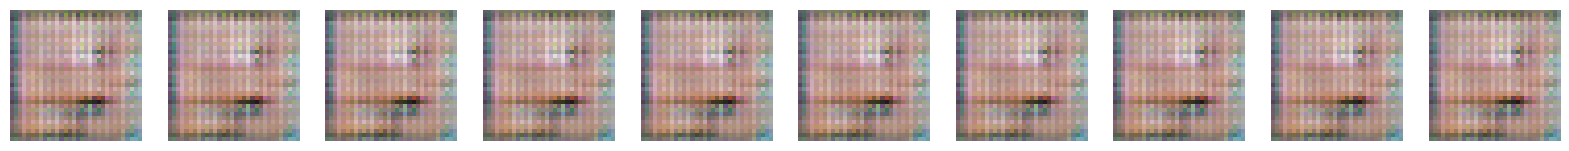

1/1 [==============================] - 0s 37ms/step
2551 [D loss: 0.185488, acc.: 98.44%] [G loss: 2.036344]
1/1 [==============================] - 0s 23ms/step
2552 [D loss: 0.149692, acc.: 98.44%] [G loss: 2.131428]
1/1 [==============================] - 0s 24ms/step
2553 [D loss: 0.345397, acc.: 92.19%] [G loss: 1.916537]
1/1 [==============================] - 0s 24ms/step
2554 [D loss: 0.180912, acc.: 95.31%] [G loss: 2.090160]
1/1 [==============================] - 0s 32ms/step
2555 [D loss: 0.378777, acc.: 90.62%] [G loss: 1.734212]
1/1 [==============================] - 0s 31ms/step
2556 [D loss: 0.272124, acc.: 92.19%] [G loss: 1.715269]
1/1 [==============================] - 0s 31ms/step
2557 [D loss: 0.214899, acc.: 95.31%] [G loss: 1.841972]
1/1 [==============================] - 0s 28ms/step
2558 [D loss: 0.212448, acc.: 96.88%] [G loss: 1.937481]
1/1 [==============================] - 0s 27ms/step
2559 [D loss: 0.240025, acc.: 92.19%] [G loss: 1.990348]
1/1 [==============

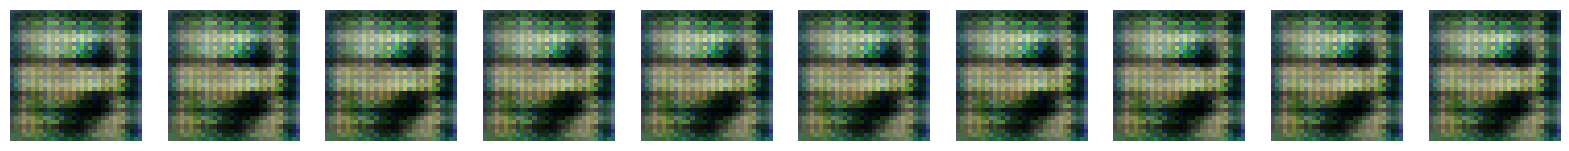

1/1 [==============================] - 0s 30ms/step
2601 [D loss: 0.160921, acc.: 95.31%] [G loss: 2.916914]
1/1 [==============================] - 0s 23ms/step
2602 [D loss: 0.153995, acc.: 93.75%] [G loss: 2.920332]
1/1 [==============================] - 0s 25ms/step
2603 [D loss: 0.276740, acc.: 89.06%] [G loss: 2.355692]
1/1 [==============================] - 0s 33ms/step
2604 [D loss: 0.169001, acc.: 98.44%] [G loss: 2.743649]
1/1 [==============================] - 0s 29ms/step
2605 [D loss: 0.151108, acc.: 95.31%] [G loss: 2.823828]
1/1 [==============================] - 0s 30ms/step
2606 [D loss: 0.278745, acc.: 84.38%] [G loss: 2.597139]
1/1 [==============================] - 0s 35ms/step
2607 [D loss: 0.222100, acc.: 93.75%] [G loss: 2.871742]
1/1 [==============================] - 0s 53ms/step
2608 [D loss: 0.276933, acc.: 90.62%] [G loss: 2.671021]
1/1 [==============================] - 0s 54ms/step
2609 [D loss: 0.212486, acc.: 92.19%] [G loss: 2.629443]
1/1 [==============

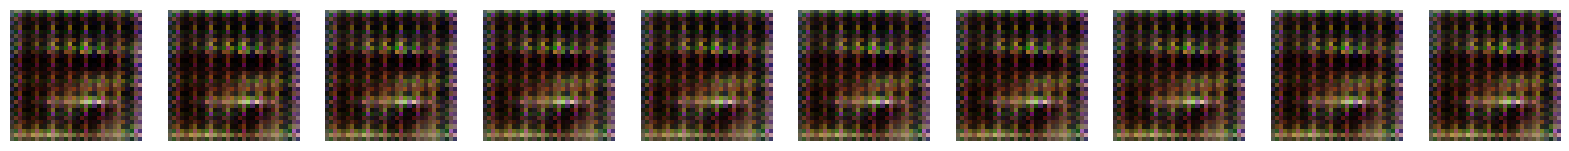

1/1 [==============================] - 0s 21ms/step
2651 [D loss: 0.250342, acc.: 89.06%] [G loss: 3.216042]
1/1 [==============================] - 0s 21ms/step
2652 [D loss: 0.183445, acc.: 92.19%] [G loss: 3.312200]
1/1 [==============================] - 0s 25ms/step
2653 [D loss: 0.124871, acc.: 95.31%] [G loss: 3.438991]
1/1 [==============================] - 0s 26ms/step
2654 [D loss: 0.408918, acc.: 87.50%] [G loss: 2.690865]
1/1 [==============================] - 0s 39ms/step
2655 [D loss: 0.119822, acc.: 96.88%] [G loss: 3.468465]
1/1 [==============================] - 0s 30ms/step
2656 [D loss: 0.363128, acc.: 82.81%] [G loss: 3.123626]
1/1 [==============================] - 0s 29ms/step
2657 [D loss: 0.196758, acc.: 93.75%] [G loss: 3.240041]
1/1 [==============================] - 0s 31ms/step
2658 [D loss: 0.226355, acc.: 90.62%] [G loss: 3.089443]
1/1 [==============================] - 0s 29ms/step
2659 [D loss: 0.448658, acc.: 89.06%] [G loss: 2.937163]
1/1 [==============

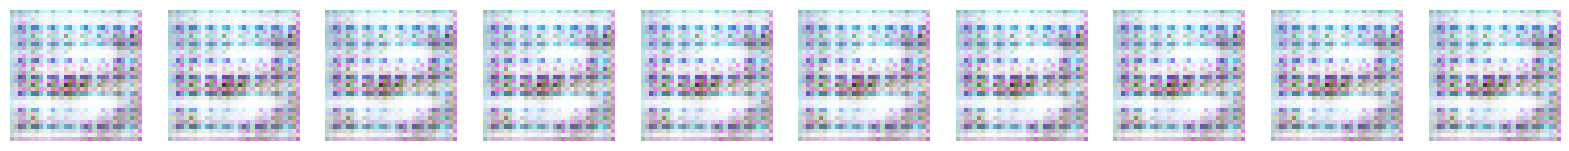

1/1 [==============================] - 0s 29ms/step
2701 [D loss: 0.457941, acc.: 85.94%] [G loss: 4.861318]
1/1 [==============================] - 0s 44ms/step
2702 [D loss: 0.554313, acc.: 84.38%] [G loss: 3.827851]
1/1 [==============================] - 0s 46ms/step
2703 [D loss: 0.156858, acc.: 98.44%] [G loss: 4.279585]
1/1 [==============================] - 0s 36ms/step
2704 [D loss: 0.331756, acc.: 89.06%] [G loss: 3.748717]
1/1 [==============================] - 0s 51ms/step
2705 [D loss: 0.445331, acc.: 89.06%] [G loss: 3.584854]
1/1 [==============================] - 0s 34ms/step
2706 [D loss: 0.167090, acc.: 95.31%] [G loss: 3.904926]
1/1 [==============================] - 0s 33ms/step
2707 [D loss: 0.752771, acc.: 82.81%] [G loss: 3.948165]
1/1 [==============================] - 0s 37ms/step
2708 [D loss: 0.154086, acc.: 93.75%] [G loss: 3.799620]
1/1 [==============================] - 0s 48ms/step
2709 [D loss: 0.198108, acc.: 93.75%] [G loss: 3.517243]
1/1 [==============

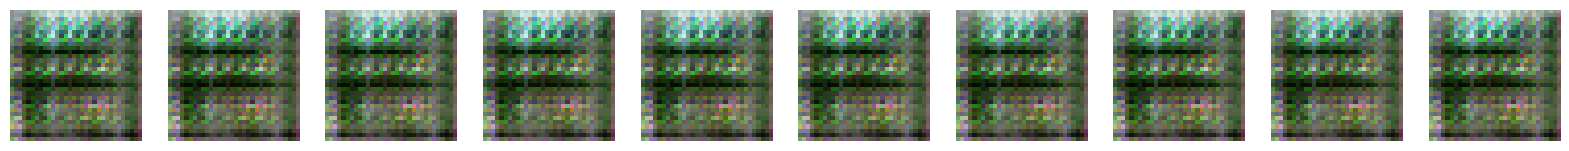

1/1 [==============================] - 0s 21ms/step
2751 [D loss: 0.252446, acc.: 93.75%] [G loss: 2.450830]
1/1 [==============================] - 0s 18ms/step
2752 [D loss: 0.193893, acc.: 96.88%] [G loss: 2.529243]
1/1 [==============================] - 0s 21ms/step
2753 [D loss: 0.226477, acc.: 92.19%] [G loss: 2.391398]
1/1 [==============================] - 0s 19ms/step
2754 [D loss: 0.318344, acc.: 93.75%] [G loss: 2.490675]
1/1 [==============================] - 0s 33ms/step
2755 [D loss: 0.360335, acc.: 85.94%] [G loss: 2.253727]
1/1 [==============================] - 0s 34ms/step
2756 [D loss: 0.397596, acc.: 81.25%] [G loss: 2.221500]
1/1 [==============================] - 0s 26ms/step
2757 [D loss: 0.220806, acc.: 93.75%] [G loss: 2.571222]
1/1 [==============================] - 0s 33ms/step
2758 [D loss: 0.329517, acc.: 89.06%] [G loss: 2.571189]
1/1 [==============================] - 0s 40ms/step
2759 [D loss: 0.243236, acc.: 93.75%] [G loss: 2.635130]
1/1 [==============

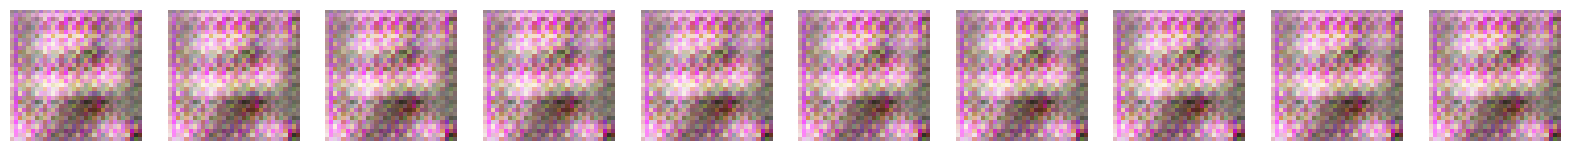

1/1 [==============================] - 0s 37ms/step
2801 [D loss: 0.225776, acc.: 95.31%] [G loss: 2.515442]
1/1 [==============================] - 0s 23ms/step
2802 [D loss: 0.232859, acc.: 93.75%] [G loss: 2.641691]
1/1 [==============================] - 0s 40ms/step
2803 [D loss: 0.302605, acc.: 92.19%] [G loss: 2.873071]
1/1 [==============================] - 0s 25ms/step
2804 [D loss: 0.510099, acc.: 87.50%] [G loss: 2.396871]
1/1 [==============================] - 0s 29ms/step
2805 [D loss: 0.506045, acc.: 89.06%] [G loss: 2.164675]
1/1 [==============================] - 0s 32ms/step
2806 [D loss: 0.365321, acc.: 89.06%] [G loss: 2.203033]
1/1 [==============================] - 0s 40ms/step
2807 [D loss: 0.176790, acc.: 95.31%] [G loss: 2.215558]
1/1 [==============================] - 0s 27ms/step
2808 [D loss: 0.237387, acc.: 93.75%] [G loss: 1.996552]
1/1 [==============================] - 0s 30ms/step
2809 [D loss: 0.648870, acc.: 82.81%] [G loss: 1.633236]
1/1 [==============

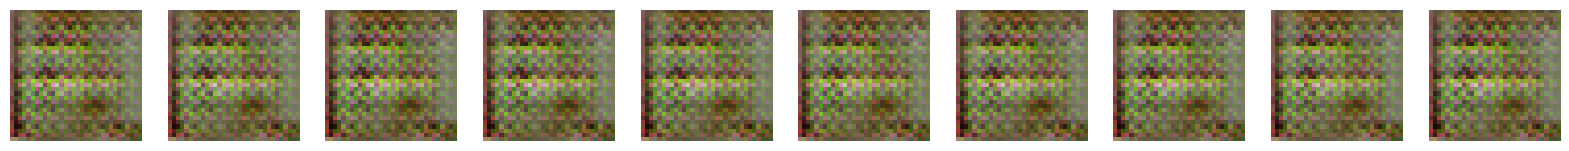

1/1 [==============================] - 0s 32ms/step
2851 [D loss: 0.242994, acc.: 96.88%] [G loss: 1.912220]
1/1 [==============================] - 0s 52ms/step
2852 [D loss: 0.360589, acc.: 89.06%] [G loss: 1.826932]
1/1 [==============================] - 0s 40ms/step
2853 [D loss: 0.256728, acc.: 93.75%] [G loss: 1.702713]
1/1 [==============================] - 0s 37ms/step
2854 [D loss: 0.275383, acc.: 95.31%] [G loss: 1.646701]
1/1 [==============================] - 0s 44ms/step
2855 [D loss: 0.373179, acc.: 90.62%] [G loss: 1.532866]
1/1 [==============================] - 0s 49ms/step
2856 [D loss: 0.381769, acc.: 90.62%] [G loss: 1.433934]
1/1 [==============================] - 0s 70ms/step
2857 [D loss: 0.598732, acc.: 75.00%] [G loss: 1.251202]
1/1 [==============================] - 0s 56ms/step
2858 [D loss: 0.409587, acc.: 79.69%] [G loss: 1.230102]
1/1 [==============================] - 0s 50ms/step
2859 [D loss: 0.484103, acc.: 75.00%] [G loss: 1.293461]
1/1 [==============

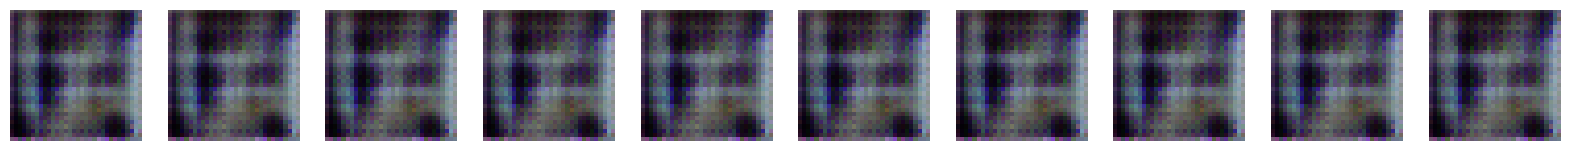

1/1 [==============================] - 0s 26ms/step
2901 [D loss: 0.265643, acc.: 95.31%] [G loss: 2.924232]
1/1 [==============================] - 0s 22ms/step
2902 [D loss: 0.339821, acc.: 93.75%] [G loss: 3.312466]
1/1 [==============================] - 0s 29ms/step
2903 [D loss: 0.282007, acc.: 90.62%] [G loss: 3.039131]
1/1 [==============================] - 0s 35ms/step
2904 [D loss: 0.354903, acc.: 87.50%] [G loss: 2.858584]
1/1 [==============================] - 0s 20ms/step
2905 [D loss: 0.248094, acc.: 90.62%] [G loss: 3.275298]
1/1 [==============================] - 0s 27ms/step
2906 [D loss: 0.413650, acc.: 87.50%] [G loss: 3.371111]
1/1 [==============================] - 0s 30ms/step
2907 [D loss: 0.440782, acc.: 84.38%] [G loss: 2.997259]
1/1 [==============================] - 0s 28ms/step
2908 [D loss: 0.492207, acc.: 81.25%] [G loss: 2.924440]
1/1 [==============================] - 0s 32ms/step
2909 [D loss: 0.653066, acc.: 73.44%] [G loss: 3.681539]
1/1 [==============

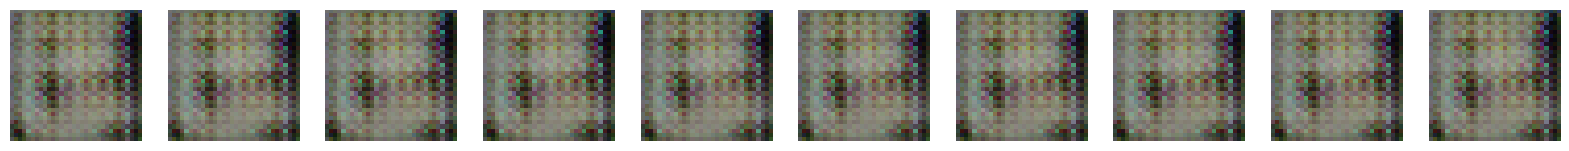

1/1 [==============================] - 0s 18ms/step
2951 [D loss: 0.355924, acc.: 90.62%] [G loss: 1.604090]
1/1 [==============================] - 0s 24ms/step
2952 [D loss: 0.325256, acc.: 90.62%] [G loss: 1.655913]
1/1 [==============================] - 0s 28ms/step
2953 [D loss: 0.218153, acc.: 96.88%] [G loss: 1.818074]
1/1 [==============================] - 0s 30ms/step
2954 [D loss: 0.220173, acc.: 98.44%] [G loss: 1.607674]
1/1 [==============================] - 0s 28ms/step
2955 [D loss: 0.360020, acc.: 90.62%] [G loss: 1.396717]
1/1 [==============================] - 0s 29ms/step
2956 [D loss: 0.368834, acc.: 90.62%] [G loss: 1.256273]
1/1 [==============================] - 0s 28ms/step
2957 [D loss: 0.312354, acc.: 93.75%] [G loss: 1.350259]
1/1 [==============================] - 0s 30ms/step
2958 [D loss: 0.391436, acc.: 89.06%] [G loss: 1.331651]
1/1 [==============================] - 0s 27ms/step
2959 [D loss: 0.437801, acc.: 81.25%] [G loss: 1.154798]
1/1 [==============

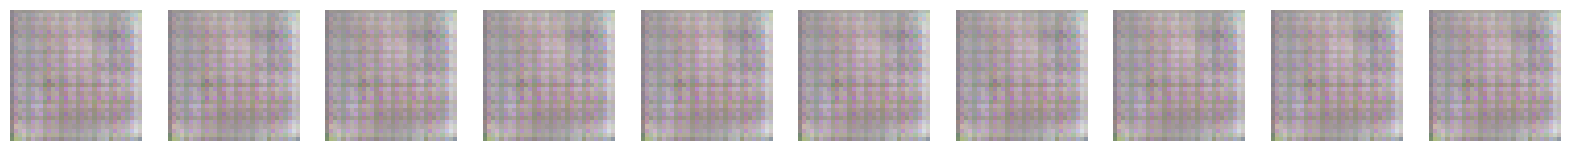

1/1 [==============================] - 0s 29ms/step
3001 [D loss: 0.218771, acc.: 93.75%] [G loss: 2.246621]
1/1 [==============================] - 0s 39ms/step
3002 [D loss: 0.195382, acc.: 95.31%] [G loss: 2.294965]
1/1 [==============================] - 0s 50ms/step
3003 [D loss: 0.408108, acc.: 90.62%] [G loss: 1.987808]
1/1 [==============================] - 0s 50ms/step
3004 [D loss: 0.240150, acc.: 93.75%] [G loss: 2.158439]
1/1 [==============================] - 0s 44ms/step
3005 [D loss: 0.244187, acc.: 95.31%] [G loss: 2.289239]
1/1 [==============================] - 0s 40ms/step
3006 [D loss: 0.155224, acc.: 96.88%] [G loss: 2.496623]
1/1 [==============================] - 0s 35ms/step
3007 [D loss: 0.231641, acc.: 93.75%] [G loss: 2.304417]
1/1 [==============================] - 0s 43ms/step
3008 [D loss: 0.299169, acc.: 92.19%] [G loss: 2.224217]
1/1 [==============================] - 0s 37ms/step
3009 [D loss: 0.106845, acc.: 98.44%] [G loss: 2.383214]
1/1 [==============

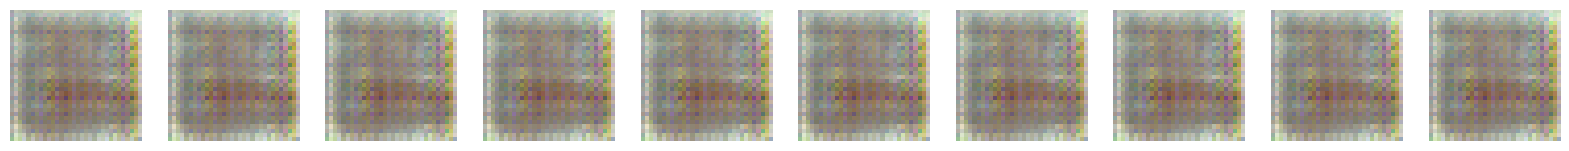

1/1 [==============================] - 0s 39ms/step
3051 [D loss: 0.223919, acc.: 96.88%] [G loss: 2.019847]
1/1 [==============================] - 0s 24ms/step
3052 [D loss: 0.133104, acc.: 96.88%] [G loss: 2.029131]
1/1 [==============================] - 0s 43ms/step
3053 [D loss: 0.197936, acc.: 96.88%] [G loss: 1.963119]
1/1 [==============================] - 0s 31ms/step
3054 [D loss: 0.168976, acc.: 96.88%] [G loss: 1.838855]
1/1 [==============================] - 0s 34ms/step
3055 [D loss: 0.279191, acc.: 96.88%] [G loss: 1.699823]
1/1 [==============================] - 0s 29ms/step
3056 [D loss: 0.204315, acc.: 98.44%] [G loss: 1.683035]
1/1 [==============================] - 0s 28ms/step
3057 [D loss: 0.307796, acc.: 96.88%] [G loss: 1.568561]
1/1 [==============================] - 0s 27ms/step
3058 [D loss: 0.477681, acc.: 90.62%] [G loss: 1.315672]
1/1 [==============================] - 0s 33ms/step
3059 [D loss: 0.322220, acc.: 87.50%] [G loss: 1.366812]
1/1 [==============

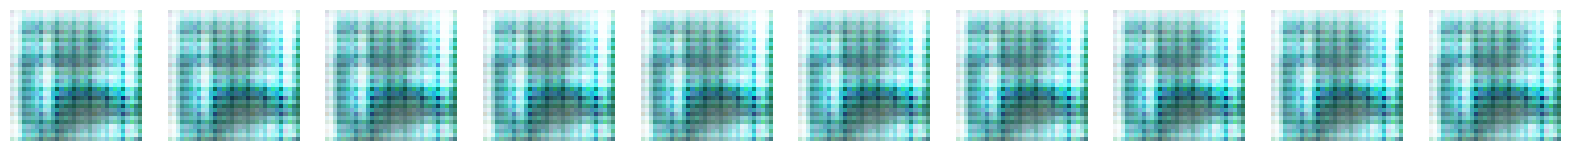

1/1 [==============================] - 0s 35ms/step
3101 [D loss: 0.263677, acc.: 95.31%] [G loss: 4.166100]
1/1 [==============================] - 0s 26ms/step
3102 [D loss: 0.331196, acc.: 89.06%] [G loss: 4.319431]
1/1 [==============================] - 0s 31ms/step
3103 [D loss: 0.345426, acc.: 93.75%] [G loss: 4.911034]
1/1 [==============================] - 0s 42ms/step
3104 [D loss: 0.328950, acc.: 92.19%] [G loss: 4.550311]
1/1 [==============================] - 0s 44ms/step
3105 [D loss: 0.273120, acc.: 90.62%] [G loss: 4.189827]
1/1 [==============================] - 0s 35ms/step
3106 [D loss: 0.638789, acc.: 79.69%] [G loss: 6.148961]
1/1 [==============================] - 0s 44ms/step
3107 [D loss: 0.557126, acc.: 82.81%] [G loss: 4.682491]
1/1 [==============================] - 0s 36ms/step
3108 [D loss: 0.318279, acc.: 87.50%] [G loss: 4.284107]
1/1 [==============================] - 0s 32ms/step
3109 [D loss: 0.275399, acc.: 93.75%] [G loss: 4.094209]
1/1 [==============

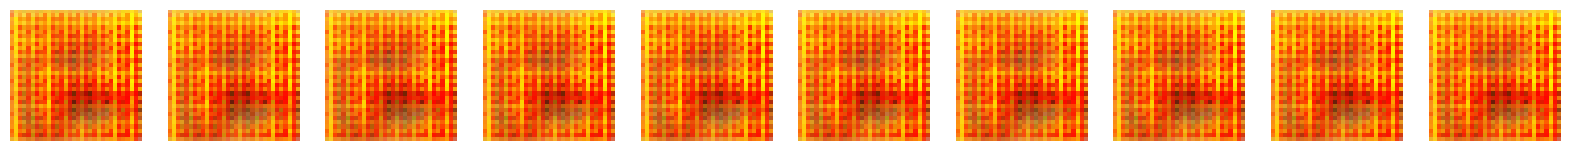

1/1 [==============================] - 0s 20ms/step
3151 [D loss: 0.252710, acc.: 96.88%] [G loss: 4.850935]
1/1 [==============================] - 0s 19ms/step
3152 [D loss: 0.224769, acc.: 93.75%] [G loss: 4.732662]
1/1 [==============================] - 0s 30ms/step
3153 [D loss: 0.194812, acc.: 92.19%] [G loss: 5.094530]
1/1 [==============================] - 0s 35ms/step
3154 [D loss: 0.078281, acc.: 98.44%] [G loss: 4.720407]
1/1 [==============================] - 0s 38ms/step
3155 [D loss: 0.109761, acc.: 98.44%] [G loss: 4.623049]
1/1 [==============================] - 0s 27ms/step
3156 [D loss: 0.036247, acc.: 100.00%] [G loss: 4.260881]
1/1 [==============================] - 0s 28ms/step
3157 [D loss: 0.025356, acc.: 100.00%] [G loss: 4.458382]
1/1 [==============================] - 0s 34ms/step
3158 [D loss: 0.188437, acc.: 89.06%] [G loss: 4.163743]
1/1 [==============================] - 0s 28ms/step
3159 [D loss: 0.261642, acc.: 87.50%] [G loss: 4.591881]
1/1 [============

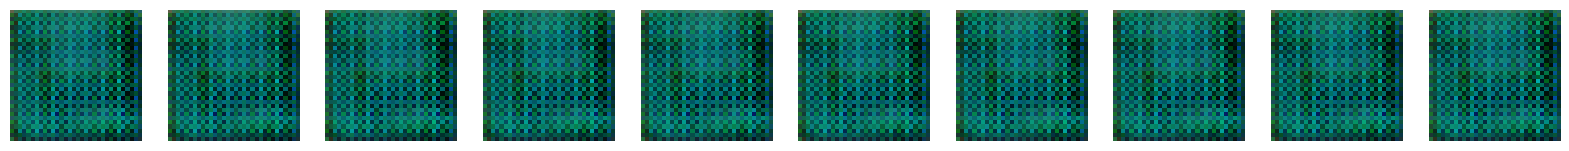

1/1 [==============================] - 0s 32ms/step
3201 [D loss: 0.314020, acc.: 95.31%] [G loss: 3.213876]
1/1 [==============================] - 0s 20ms/step
3202 [D loss: 0.106791, acc.: 93.75%] [G loss: 3.297850]
1/1 [==============================] - 0s 21ms/step
3203 [D loss: 0.179117, acc.: 90.62%] [G loss: 3.010564]
1/1 [==============================] - 0s 27ms/step
3204 [D loss: 0.175238, acc.: 95.31%] [G loss: 3.152781]
1/1 [==============================] - 0s 30ms/step
3205 [D loss: 0.113445, acc.: 95.31%] [G loss: 3.170859]
1/1 [==============================] - 0s 29ms/step
3206 [D loss: 0.055144, acc.: 98.44%] [G loss: 3.441006]
1/1 [==============================] - 0s 26ms/step
3207 [D loss: 0.130654, acc.: 93.75%] [G loss: 3.516486]
1/1 [==============================] - 0s 21ms/step
3208 [D loss: 0.096483, acc.: 96.88%] [G loss: 3.348485]
1/1 [==============================] - 0s 28ms/step
3209 [D loss: 0.110059, acc.: 93.75%] [G loss: 3.384782]
1/1 [==============

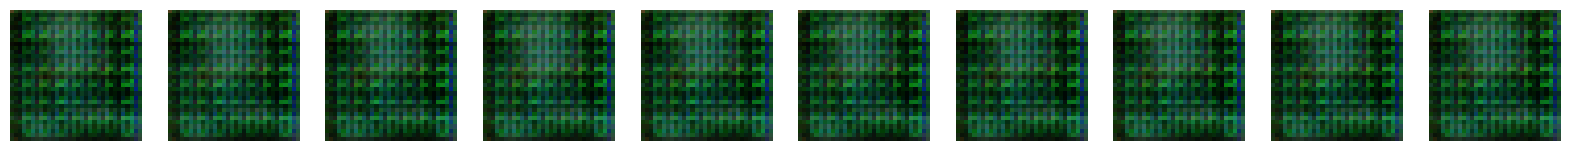

1/1 [==============================] - 0s 19ms/step
3251 [D loss: 0.135870, acc.: 96.88%] [G loss: 3.153032]
1/1 [==============================] - 0s 19ms/step
3252 [D loss: 0.068360, acc.: 98.44%] [G loss: 3.642634]
1/1 [==============================] - 0s 27ms/step
3253 [D loss: 0.071192, acc.: 98.44%] [G loss: 3.847010]
1/1 [==============================] - 0s 28ms/step
3254 [D loss: 0.082279, acc.: 96.88%] [G loss: 3.680270]
1/1 [==============================] - 0s 29ms/step
3255 [D loss: 0.097874, acc.: 93.75%] [G loss: 3.428774]
1/1 [==============================] - 0s 29ms/step
3256 [D loss: 0.049370, acc.: 98.44%] [G loss: 3.702364]
1/1 [==============================] - 0s 25ms/step
3257 [D loss: 0.130459, acc.: 95.31%] [G loss: 3.484463]
1/1 [==============================] - 0s 27ms/step
3258 [D loss: 0.177653, acc.: 96.88%] [G loss: 3.115809]
1/1 [==============================] - 0s 35ms/step
3259 [D loss: 0.063342, acc.: 98.44%] [G loss: 3.541568]
1/1 [==============

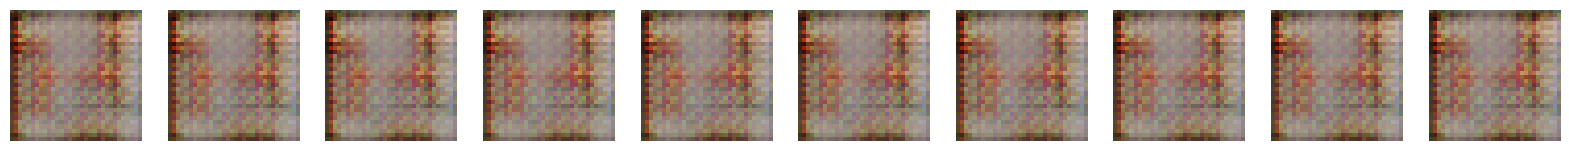

1/1 [==============================] - 0s 23ms/step
3301 [D loss: 0.368815, acc.: 89.06%] [G loss: 1.135451]
1/1 [==============================] - 0s 18ms/step
3302 [D loss: 0.428115, acc.: 81.25%] [G loss: 1.243873]
1/1 [==============================] - 0s 18ms/step
3303 [D loss: 0.474885, acc.: 75.00%] [G loss: 1.084406]
1/1 [==============================] - 0s 29ms/step
3304 [D loss: 0.611867, acc.: 64.06%] [G loss: 1.141779]
1/1 [==============================] - 0s 38ms/step
3305 [D loss: 0.451154, acc.: 71.88%] [G loss: 1.202365]
1/1 [==============================] - 0s 29ms/step
3306 [D loss: 0.378383, acc.: 82.81%] [G loss: 1.295241]
1/1 [==============================] - 0s 29ms/step
3307 [D loss: 0.350872, acc.: 90.62%] [G loss: 1.563607]
1/1 [==============================] - 0s 27ms/step
3308 [D loss: 0.290878, acc.: 95.31%] [G loss: 1.653464]
1/1 [==============================] - 0s 31ms/step
3309 [D loss: 0.325322, acc.: 96.88%] [G loss: 1.926089]
1/1 [==============

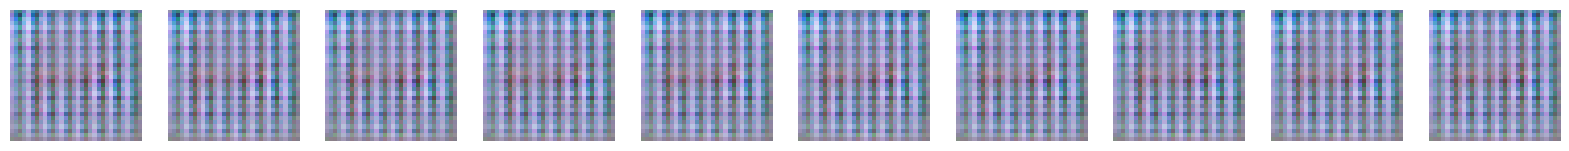

1/1 [==============================] - 0s 30ms/step
3351 [D loss: 0.150161, acc.: 93.75%] [G loss: 3.209746]
1/1 [==============================] - 0s 37ms/step
3352 [D loss: 0.069671, acc.: 100.00%] [G loss: 3.246198]
1/1 [==============================] - 0s 37ms/step
3353 [D loss: 0.137971, acc.: 95.31%] [G loss: 3.261133]
1/1 [==============================] - 0s 44ms/step
3354 [D loss: 0.121653, acc.: 93.75%] [G loss: 3.389797]
1/1 [==============================] - 0s 43ms/step
3355 [D loss: 0.196347, acc.: 93.75%] [G loss: 3.106250]
1/1 [==============================] - 0s 35ms/step
3356 [D loss: 0.123028, acc.: 96.88%] [G loss: 3.396849]
1/1 [==============================] - 0s 43ms/step
3357 [D loss: 0.106658, acc.: 98.44%] [G loss: 3.250421]
1/1 [==============================] - 0s 65ms/step
3358 [D loss: 0.125670, acc.: 95.31%] [G loss: 3.388475]
1/1 [==============================] - 0s 48ms/step
3359 [D loss: 0.098022, acc.: 98.44%] [G loss: 3.440835]
1/1 [=============

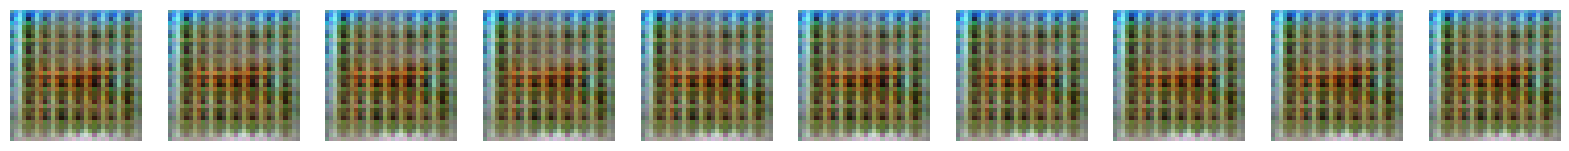

1/1 [==============================] - 0s 20ms/step
3401 [D loss: 0.339011, acc.: 85.94%] [G loss: 2.519436]
1/1 [==============================] - 0s 21ms/step
3402 [D loss: 0.217852, acc.: 93.75%] [G loss: 2.730222]
1/1 [==============================] - 0s 36ms/step
3403 [D loss: 0.288119, acc.: 90.62%] [G loss: 2.734336]
1/1 [==============================] - 0s 29ms/step
3404 [D loss: 0.212249, acc.: 90.62%] [G loss: 2.879483]
1/1 [==============================] - 0s 31ms/step
3405 [D loss: 0.152659, acc.: 92.19%] [G loss: 2.861642]
1/1 [==============================] - 0s 32ms/step
3406 [D loss: 0.168372, acc.: 92.19%] [G loss: 2.859818]
1/1 [==============================] - 0s 28ms/step
3407 [D loss: 0.232262, acc.: 92.19%] [G loss: 2.972381]
1/1 [==============================] - 0s 23ms/step
3408 [D loss: 0.247838, acc.: 93.75%] [G loss: 2.888397]
1/1 [==============================] - 0s 28ms/step
3409 [D loss: 0.169235, acc.: 90.62%] [G loss: 2.924605]
1/1 [==============

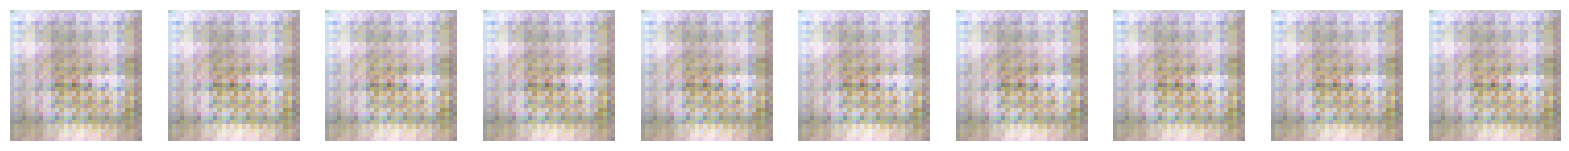

1/1 [==============================] - 0s 31ms/step
3451 [D loss: 0.158881, acc.: 93.75%] [G loss: 3.478276]
1/1 [==============================] - 0s 34ms/step
3452 [D loss: 0.133800, acc.: 96.88%] [G loss: 3.268139]
1/1 [==============================] - 0s 29ms/step
3453 [D loss: 0.129942, acc.: 96.88%] [G loss: 3.185600]
1/1 [==============================] - 0s 28ms/step
3454 [D loss: 0.267997, acc.: 90.62%] [G loss: 3.092458]
1/1 [==============================] - 0s 30ms/step
3455 [D loss: 0.230329, acc.: 95.31%] [G loss: 3.089082]
1/1 [==============================] - 0s 30ms/step
3456 [D loss: 0.122133, acc.: 98.44%] [G loss: 3.440691]
1/1 [==============================] - 0s 29ms/step
3457 [D loss: 0.165391, acc.: 93.75%] [G loss: 3.222287]
1/1 [==============================] - 0s 28ms/step
3458 [D loss: 0.143212, acc.: 96.88%] [G loss: 3.164402]
1/1 [==============================] - 0s 34ms/step
3459 [D loss: 0.242342, acc.: 92.19%] [G loss: 2.907389]
1/1 [==============

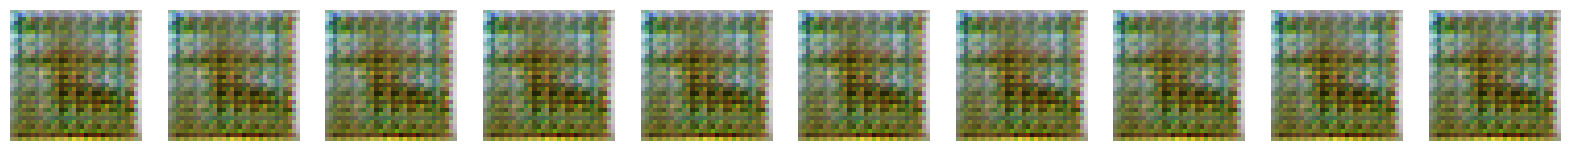

1/1 [==============================] - 0s 19ms/step
3501 [D loss: 0.381501, acc.: 90.62%] [G loss: 3.112666]
1/1 [==============================] - 0s 18ms/step
3502 [D loss: 0.291983, acc.: 90.62%] [G loss: 3.473175]
1/1 [==============================] - 0s 19ms/step
3503 [D loss: 0.369502, acc.: 87.50%] [G loss: 3.252903]
1/1 [==============================] - 0s 28ms/step
3504 [D loss: 0.241527, acc.: 93.75%] [G loss: 3.580592]
1/1 [==============================] - 0s 31ms/step
3505 [D loss: 0.282074, acc.: 92.19%] [G loss: 3.914892]
1/1 [==============================] - 0s 47ms/step
3506 [D loss: 0.300905, acc.: 90.62%] [G loss: 3.854254]
1/1 [==============================] - 0s 42ms/step
3507 [D loss: 0.435986, acc.: 89.06%] [G loss: 4.254804]
1/1 [==============================] - 0s 29ms/step
3508 [D loss: 0.263001, acc.: 89.06%] [G loss: 4.270332]
1/1 [==============================] - 0s 57ms/step
3509 [D loss: 0.518946, acc.: 82.81%] [G loss: 4.294981]
1/1 [==============

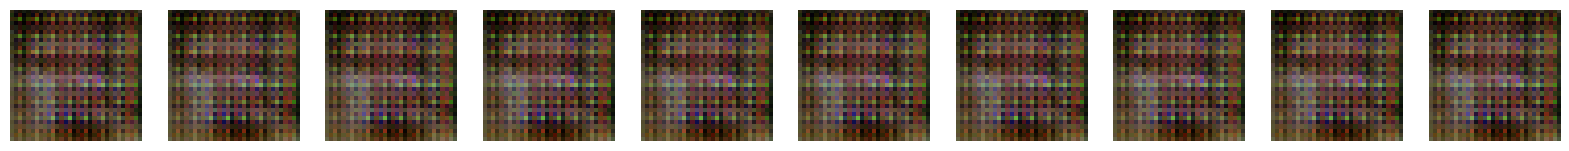

1/1 [==============================] - 0s 27ms/step
3551 [D loss: 0.247973, acc.: 90.62%] [G loss: 2.702609]
1/1 [==============================] - 0s 29ms/step
3552 [D loss: 0.259395, acc.: 92.19%] [G loss: 2.561598]
1/1 [==============================] - 0s 29ms/step
3553 [D loss: 0.103532, acc.: 98.44%] [G loss: 3.024014]
1/1 [==============================] - 0s 29ms/step
3554 [D loss: 0.296678, acc.: 90.62%] [G loss: 2.747905]
1/1 [==============================] - 0s 25ms/step
3555 [D loss: 0.202231, acc.: 92.19%] [G loss: 2.642617]
1/1 [==============================] - 0s 22ms/step
3556 [D loss: 0.124385, acc.: 96.88%] [G loss: 3.054451]
1/1 [==============================] - 0s 33ms/step
3557 [D loss: 0.167687, acc.: 93.75%] [G loss: 2.678754]
1/1 [==============================] - 0s 29ms/step
3558 [D loss: 0.272582, acc.: 89.06%] [G loss: 2.549610]
1/1 [==============================] - 0s 32ms/step
3559 [D loss: 0.174656, acc.: 93.75%] [G loss: 2.762730]
1/1 [==============

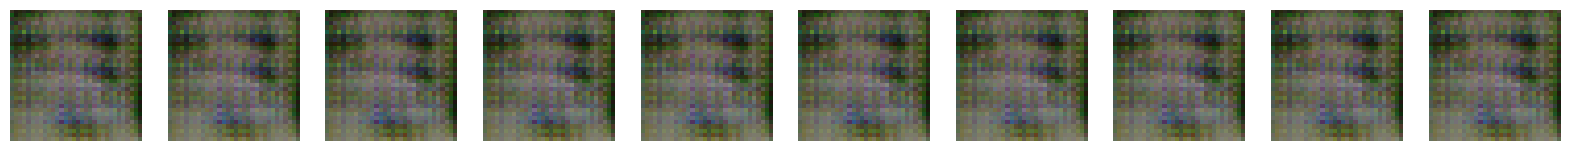

1/1 [==============================] - 0s 48ms/step
3601 [D loss: 0.189849, acc.: 93.75%] [G loss: 2.317319]
1/1 [==============================] - 0s 53ms/step
3602 [D loss: 0.193287, acc.: 93.75%] [G loss: 2.285434]
1/1 [==============================] - 0s 46ms/step
3603 [D loss: 0.164597, acc.: 93.75%] [G loss: 2.331502]
1/1 [==============================] - 0s 56ms/step
3604 [D loss: 0.226686, acc.: 93.75%] [G loss: 2.395597]
1/1 [==============================] - 0s 40ms/step
3605 [D loss: 0.102678, acc.: 100.00%] [G loss: 2.484572]
1/1 [==============================] - 0s 66ms/step
3606 [D loss: 0.157873, acc.: 95.31%] [G loss: 2.604497]
1/1 [==============================] - 0s 38ms/step
3607 [D loss: 0.200327, acc.: 93.75%] [G loss: 2.609247]
1/1 [==============================] - 0s 35ms/step
3608 [D loss: 0.209312, acc.: 92.19%] [G loss: 2.423577]
1/1 [==============================] - 0s 70ms/step
3609 [D loss: 0.180425, acc.: 93.75%] [G loss: 2.411509]
1/1 [=============

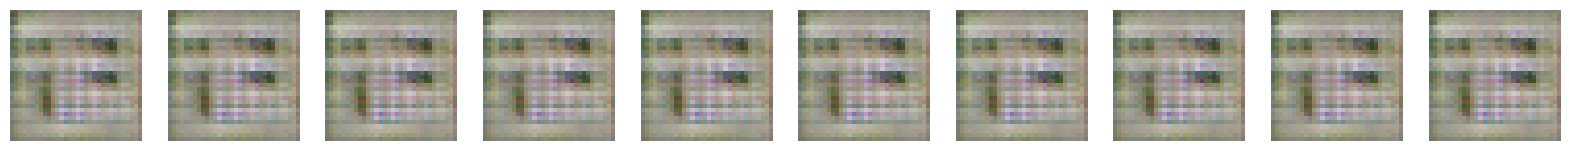

1/1 [==============================] - 0s 29ms/step
3651 [D loss: 0.482097, acc.: 67.19%] [G loss: 1.862386]
1/1 [==============================] - 0s 31ms/step
3652 [D loss: 0.382005, acc.: 90.62%] [G loss: 2.127487]
1/1 [==============================] - 0s 28ms/step
3653 [D loss: 0.214985, acc.: 98.44%] [G loss: 2.362444]
1/1 [==============================] - 0s 30ms/step
3654 [D loss: 0.189034, acc.: 95.31%] [G loss: 2.533734]
1/1 [==============================] - 0s 30ms/step
3655 [D loss: 0.154106, acc.: 95.31%] [G loss: 2.803050]
1/1 [==============================] - 0s 30ms/step
3656 [D loss: 0.158159, acc.: 95.31%] [G loss: 2.758300]
1/1 [==============================] - 0s 58ms/step
3657 [D loss: 0.156395, acc.: 95.31%] [G loss: 2.724223]
1/1 [==============================] - 0s 35ms/step
3658 [D loss: 0.144430, acc.: 96.88%] [G loss: 3.161552]
1/1 [==============================] - 0s 30ms/step
3659 [D loss: 0.094836, acc.: 98.44%] [G loss: 3.169060]
1/1 [==============

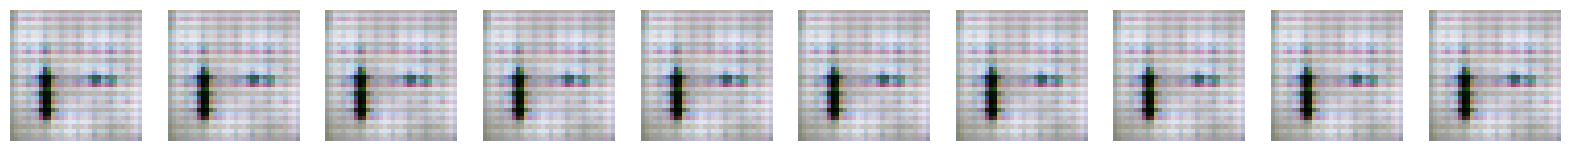

1/1 [==============================] - 0s 29ms/step
3701 [D loss: 0.164674, acc.: 95.31%] [G loss: 3.200279]
1/1 [==============================] - 0s 29ms/step
3702 [D loss: 0.060719, acc.: 98.44%] [G loss: 3.460144]
1/1 [==============================] - 0s 38ms/step
3703 [D loss: 0.334997, acc.: 87.50%] [G loss: 3.224658]
1/1 [==============================] - 0s 31ms/step
3704 [D loss: 0.084475, acc.: 96.88%] [G loss: 3.274240]
1/1 [==============================] - 0s 31ms/step
3705 [D loss: 0.136081, acc.: 96.88%] [G loss: 3.048339]
1/1 [==============================] - 0s 27ms/step
3706 [D loss: 0.123090, acc.: 96.88%] [G loss: 3.280105]
1/1 [==============================] - 0s 31ms/step
3707 [D loss: 0.113457, acc.: 95.31%] [G loss: 3.556562]
1/1 [==============================] - 0s 45ms/step
3708 [D loss: 0.185369, acc.: 93.75%] [G loss: 3.071854]
1/1 [==============================] - 0s 32ms/step
3709 [D loss: 0.199651, acc.: 93.75%] [G loss: 2.893009]
1/1 [==============

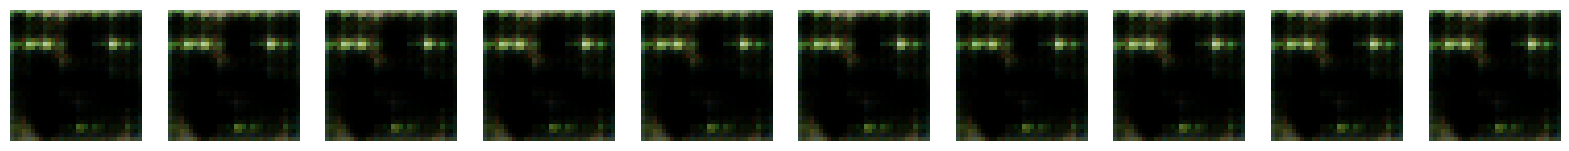

1/1 [==============================] - 0s 45ms/step
3751 [D loss: 0.301022, acc.: 89.06%] [G loss: 4.129361]
1/1 [==============================] - 0s 31ms/step
3752 [D loss: 0.137544, acc.: 95.31%] [G loss: 4.515371]
1/1 [==============================] - 0s 35ms/step
3753 [D loss: 0.264061, acc.: 90.62%] [G loss: 4.495236]
1/1 [==============================] - 0s 41ms/step
3754 [D loss: 0.181935, acc.: 90.62%] [G loss: 4.573565]
1/1 [==============================] - 0s 37ms/step
3755 [D loss: 0.184557, acc.: 92.19%] [G loss: 4.302374]
1/1 [==============================] - 0s 34ms/step
3756 [D loss: 0.194898, acc.: 89.06%] [G loss: 4.098313]
1/1 [==============================] - 0s 35ms/step
3757 [D loss: 0.105362, acc.: 95.31%] [G loss: 4.536251]
1/1 [==============================] - 0s 39ms/step
3758 [D loss: 0.370198, acc.: 85.94%] [G loss: 4.010446]
1/1 [==============================] - 0s 33ms/step
3759 [D loss: 0.118951, acc.: 95.31%] [G loss: 4.715114]
1/1 [==============

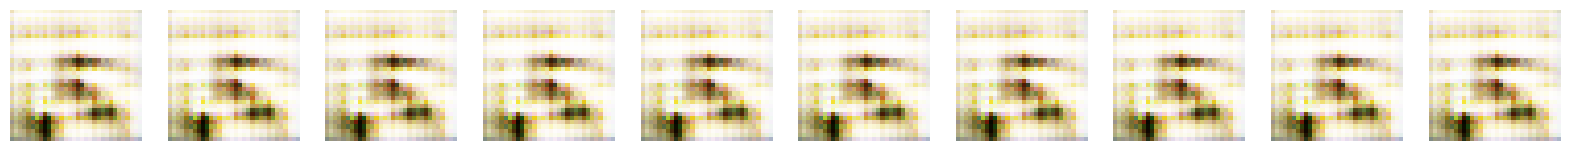

1/1 [==============================] - 0s 44ms/step
3801 [D loss: 0.456074, acc.: 90.62%] [G loss: 3.505434]
1/1 [==============================] - 0s 32ms/step
3802 [D loss: 0.205555, acc.: 95.31%] [G loss: 3.678698]
1/1 [==============================] - 0s 30ms/step
3803 [D loss: 0.435731, acc.: 89.06%] [G loss: 3.760985]
1/1 [==============================] - 0s 32ms/step
3804 [D loss: 0.487762, acc.: 85.94%] [G loss: 3.518821]
1/1 [==============================] - 0s 32ms/step
3805 [D loss: 0.353928, acc.: 92.19%] [G loss: 3.644358]
1/1 [==============================] - 0s 32ms/step
3806 [D loss: 0.344337, acc.: 90.62%] [G loss: 3.386686]
1/1 [==============================] - 0s 32ms/step
3807 [D loss: 0.284891, acc.: 92.19%] [G loss: 3.506722]
1/1 [==============================] - 0s 33ms/step
3808 [D loss: 0.518341, acc.: 92.19%] [G loss: 3.335991]
1/1 [==============================] - 0s 31ms/step
3809 [D loss: 0.266709, acc.: 95.31%] [G loss: 3.707075]
1/1 [==============

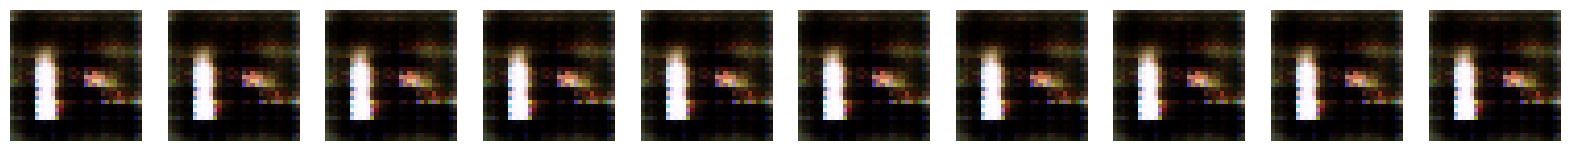

1/1 [==============================] - 0s 49ms/step
3851 [D loss: 0.119156, acc.: 95.31%] [G loss: 3.912002]
1/1 [==============================] - 0s 50ms/step
3852 [D loss: 0.169660, acc.: 93.75%] [G loss: 3.847183]
1/1 [==============================] - 0s 57ms/step
3853 [D loss: 0.365754, acc.: 87.50%] [G loss: 3.262031]
1/1 [==============================] - 0s 45ms/step
3854 [D loss: 0.245522, acc.: 92.19%] [G loss: 3.336573]
1/1 [==============================] - 0s 47ms/step
3855 [D loss: 0.214065, acc.: 90.62%] [G loss: 3.536469]
1/1 [==============================] - 0s 31ms/step
3856 [D loss: 0.209367, acc.: 95.31%] [G loss: 3.489828]
1/1 [==============================] - 0s 32ms/step
3857 [D loss: 0.120961, acc.: 98.44%] [G loss: 3.821795]
1/1 [==============================] - 0s 32ms/step
3858 [D loss: 0.291427, acc.: 89.06%] [G loss: 3.429116]
1/1 [==============================] - 0s 35ms/step
3859 [D loss: 0.288593, acc.: 92.19%] [G loss: 3.151672]
1/1 [==============

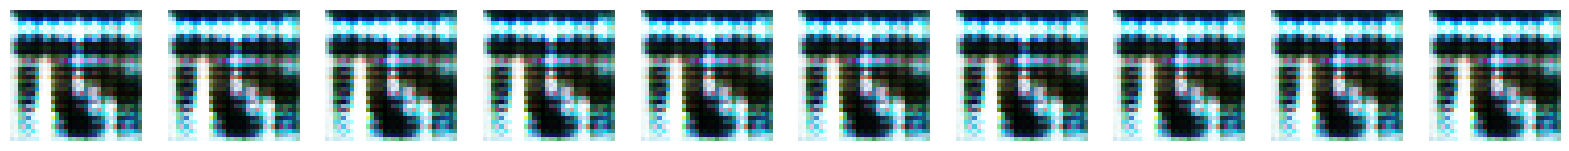

1/1 [==============================] - 0s 31ms/step
3901 [D loss: 0.091183, acc.: 96.88%] [G loss: 3.854113]
1/1 [==============================] - 0s 33ms/step
3902 [D loss: 0.347163, acc.: 89.06%] [G loss: 3.990610]
1/1 [==============================] - 0s 28ms/step
3903 [D loss: 0.168713, acc.: 96.88%] [G loss: 4.291368]
1/1 [==============================] - 0s 34ms/step
3904 [D loss: 0.069043, acc.: 100.00%] [G loss: 3.949657]
1/1 [==============================] - 0s 48ms/step
3905 [D loss: 0.064568, acc.: 100.00%] [G loss: 3.961205]
1/1 [==============================] - 0s 35ms/step
3906 [D loss: 0.157954, acc.: 95.31%] [G loss: 3.654314]
1/1 [==============================] - 0s 31ms/step
3907 [D loss: 0.162924, acc.: 92.19%] [G loss: 3.635165]
1/1 [==============================] - 0s 35ms/step
3908 [D loss: 0.058430, acc.: 100.00%] [G loss: 4.230453]
1/1 [==============================] - 0s 27ms/step
3909 [D loss: 0.171531, acc.: 93.75%] [G loss: 3.575848]
1/1 [===========

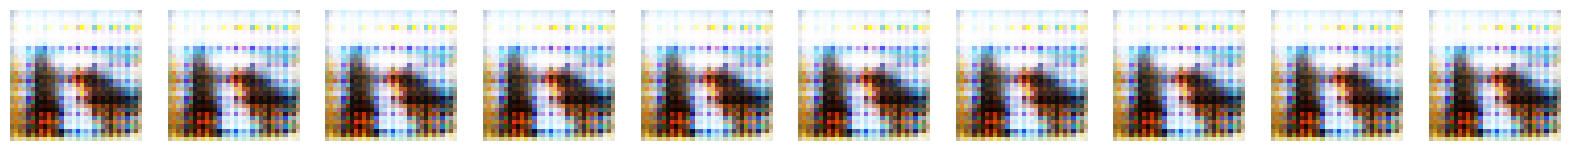

1/1 [==============================] - 0s 30ms/step
3951 [D loss: 0.356938, acc.: 92.19%] [G loss: 3.527054]
1/1 [==============================] - 0s 30ms/step
3952 [D loss: 0.168666, acc.: 96.88%] [G loss: 3.530578]
1/1 [==============================] - 0s 28ms/step
3953 [D loss: 0.248375, acc.: 89.06%] [G loss: 3.420938]
1/1 [==============================] - 0s 31ms/step
3954 [D loss: 0.167892, acc.: 93.75%] [G loss: 3.682712]
1/1 [==============================] - 0s 26ms/step
3955 [D loss: 0.180918, acc.: 96.88%] [G loss: 3.418811]
1/1 [==============================] - 0s 28ms/step
3956 [D loss: 0.334848, acc.: 93.75%] [G loss: 3.210794]
1/1 [==============================] - 0s 31ms/step
3957 [D loss: 0.545629, acc.: 76.56%] [G loss: 3.182213]
1/1 [==============================] - 0s 40ms/step
3958 [D loss: 0.345449, acc.: 89.06%] [G loss: 3.304445]
1/1 [==============================] - 0s 28ms/step
3959 [D loss: 0.177041, acc.: 96.88%] [G loss: 3.379900]
1/1 [==============

In [ ]:
import numpy as np

epochs = 4000
batch_size = 32
display_interval = 50
losses = []

# Adversarial ground truths valid = 1, fake = 0
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]

    # Generate random labels for the batch of real images
    sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
    gen_imgs = generator.predict([noise, fake_labels])

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator (wants discriminator to mistake images as real)
    g_loss = combined_network.train_on_batch([noise, fake_labels], valid)

    # Plot the progress
    print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

    # If at save interval => save generated image samples
    if epoch % display_interval == 0:
        display_images(generator, latent_dim, num_classes)


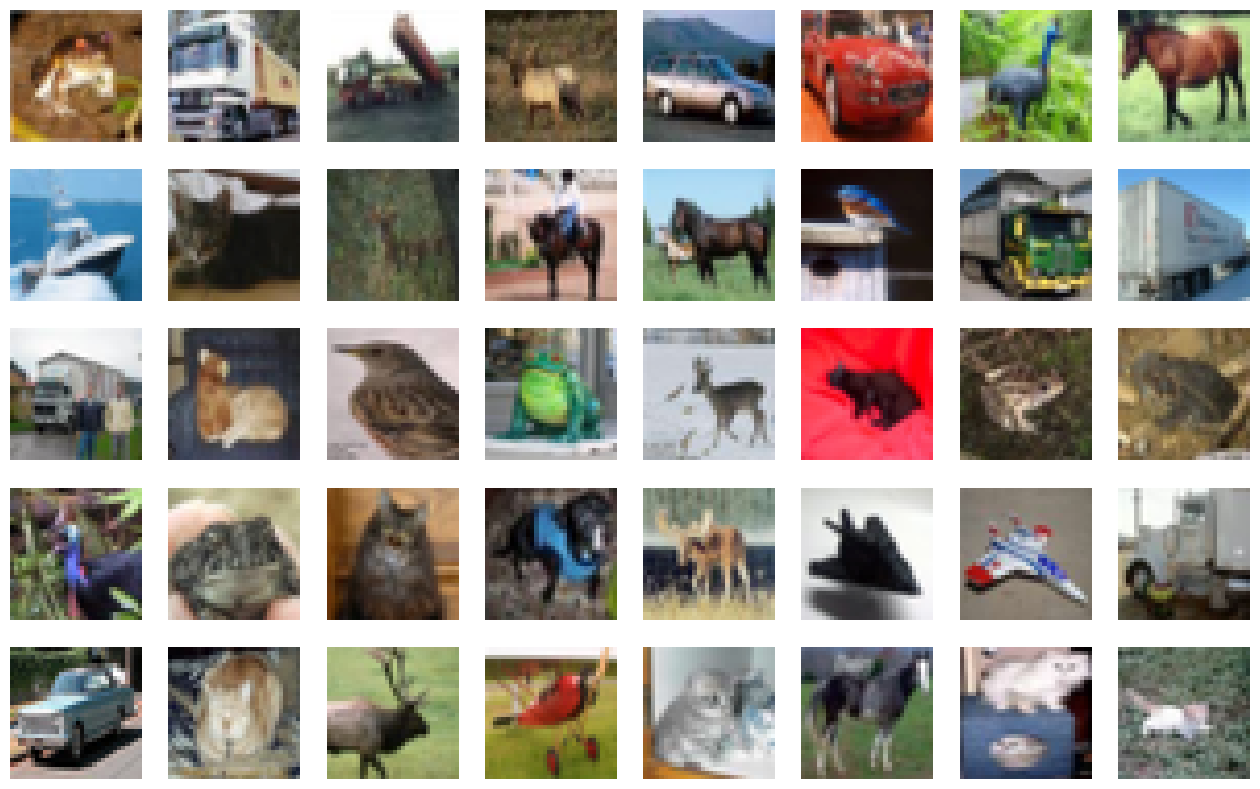

In [ ]:
#Plotting some of the original images
s=x_train[:40]
s = 0.5 * s + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, image in enumerate(s):
    ax[i//8, i%8].imshow(image, cmap='gray')
    ax[i//8, i%8].axis('off')

plt.show()

2/2 [==============================] - 0s 274ms/step


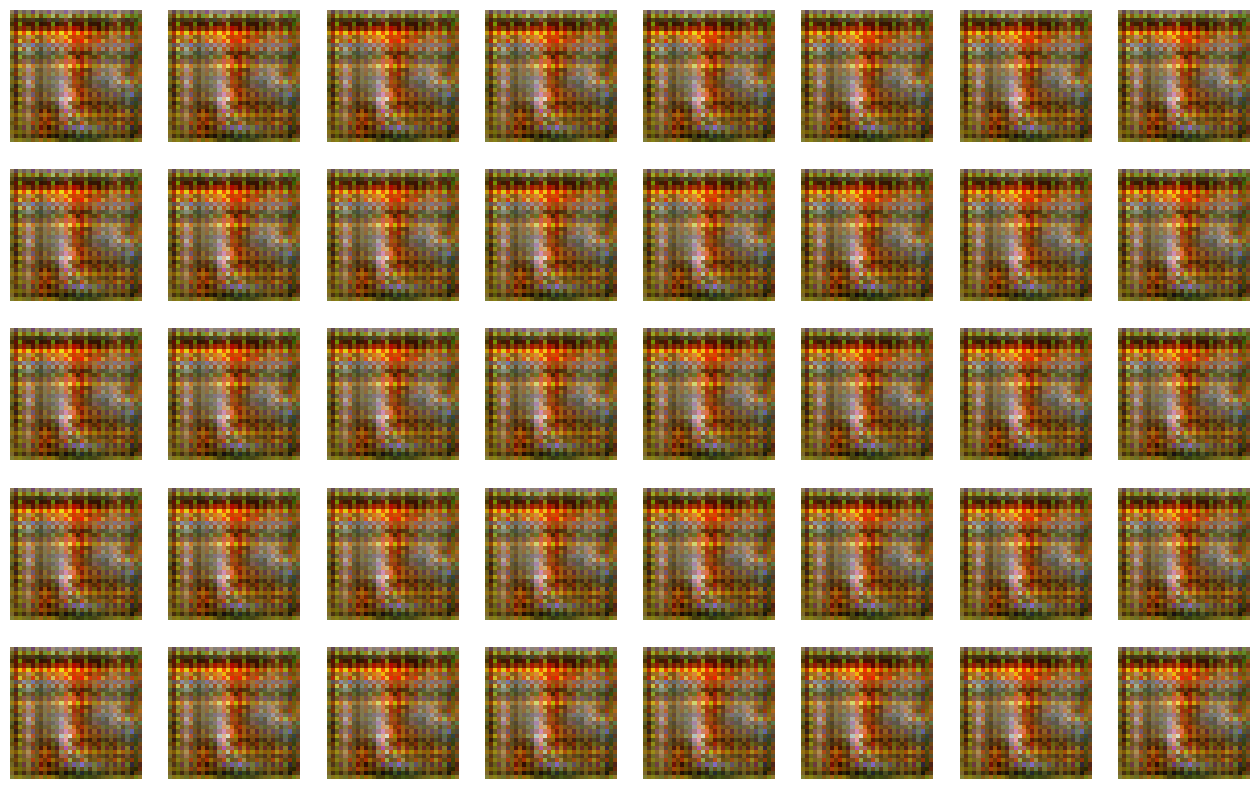

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random noise and corresponding labels
noise = np.random.normal(size=(40, latent_dim))
sampled_labels = np.array([num for _ in range(4) for num in range(10)])

# Generate images using the generator
generated_images = generator.predict([noise, sampled_labels])

# Rescale images to 0 - 1
generated_images = 0.5 * generated_images + 0.5

# Display the generated images
f, ax = plt.subplots(5, 8, figsize=(16, 10))
for i, image in enumerate(generated_images):
    ax[i // 8, i % 8].imshow(image)
    ax[i // 8, i % 8].axis('off')

plt.show()
